## Alternus Vera - Analysis
**Amrutha Singh Balaji Singh**

**Student ID - 013778583**

**Team - Transformers**

* The goal of the project is to develop a strategy to help identify fake news from real news and understand the influence of Controversy and other factors. 
* The subject of fake news became popular in connection with the recent US presidential elections and with possible Russian meddling into elections in the US, France, and Germany. 
* The project uses LIAR - LIAR dataset.

## Factor - Controversy

Controversial content can be defined as any contentious matter or argument that may spark public debate. The approach is motivated by several factors. First, news is a significant part of our everyday lives. It shapes our beliefs and opinions on how we see the world and now more than ever people rely on a variety of online resources for their news. 

Therefore, the aim is to identify the potential of using single keywords to detect controversial content or topics that will influence fake news by applying Distillation process and multi-label classifiers.

Distillation
* LDA, LSA, TF-Idf, Doc2vec gensim models and sentiment analysis methods.

* Scoring Component: To detect the posts that cast controversy on the article and score the controversy level.
* Ranking Component: Ranked the articles based on the controversy scores of each statement.

**Updates:**

Added KNN, Random Forest algorithms
Updated the path of the datasets to the shared folder on drive 

**Accuracy Table:**

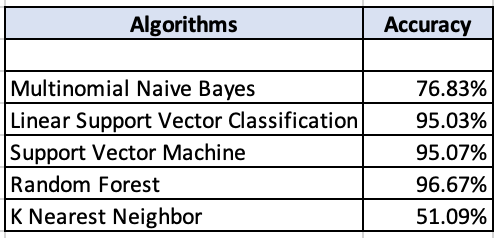


In [161]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from graphviz import Digraph
from collections import OrderedDict
import seaborn as sns
sns.set_style("darkgrid")

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from google.colab import drive
drive.mount('/content/drive')
path_train = '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/train.tsv'
path_test='/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/test.tsv'
path_valid='/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/valid.tsv'
path_controversy_vocab = '/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/controversy_vocabulary.csv'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Train, Test and Validation data

In [0]:
train_data = pd.read_csv(path_train, sep='\t', header = None)
test_data = pd.read_csv(path_test, sep='\t', header = None)
valid_data = pd.read_csv(path_valid, sep='\t', header = None)

contro_vocab_data = pd.read_csv(path_controversy_vocab)
contro_vocab_data.head()
columns = ['id', 'label', 'statement', 'subjects', 'speaker',
         'speaker_job', 'state', 'party', 'barely_true_counts',
         'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
         'context']
train_data.columns = columns
test_data.columns = columns
valid_data.columns = columns


#### Adding text length to training set

In [164]:
train_data['text-length'] = train_data['statement'].apply(len)
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,text-length
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,82
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,141
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,105
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,78
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,54


## Visualizing the dataset 

### Distribution of classes based on labels - Train ,Test and Validation datasets

In [165]:
train_data.subjects.unique()

array(['abortion', 'energy,history,job-accomplishments', 'foreign-policy',
       ..., 'animals,elections', 'retirement,social-security',
       'florida,foreign-policy'], dtype=object)

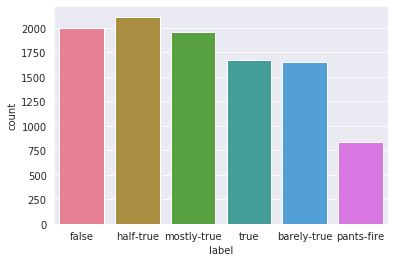

In [166]:
sb.countplot(x='label', data=train_data, palette='husl')

* Here, we see that the number of articles per class is roughly balanced, which is helpful!

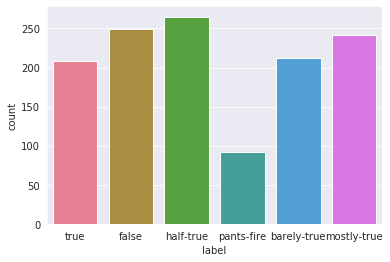

In [167]:
sb.countplot(x='label', data=test_data, palette='husl')

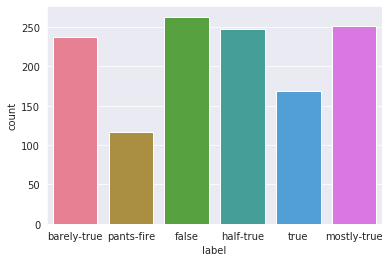

In [168]:
sb.countplot(x='label', data=valid_data, palette='husl')

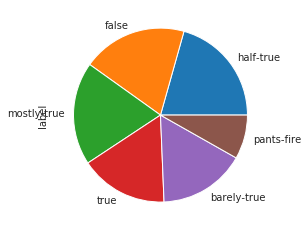

In [169]:
%matplotlib inline
train_data['label'].value_counts().plot(kind="pie")

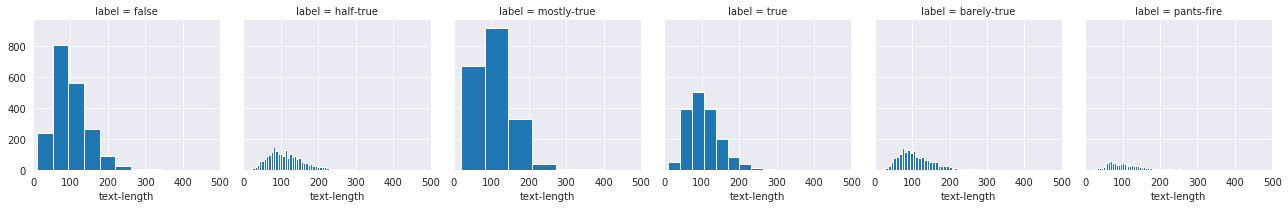

In [170]:
g = sns.FacetGrid(data=train_data, col='label')
for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
       ax.set_xlim(0,500)
g.map(plt.hist, 'text-length', bins=50)


* Seems like overall, the distribution of text length is similar across all labels. However, the number of text length seems to be skewed a lot higher for false and mostly-true labels. 

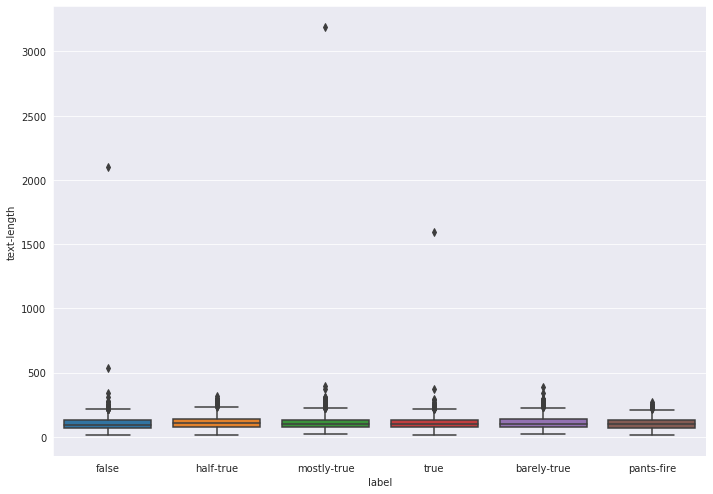

In [171]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
sns.boxplot(x='label', y='text-length', data=train_data)

#### From the plot I  inferred that 'false' 'mostly-true' and 'true' have much longer text, but there are many outliers too which can be seen as points above the boxes

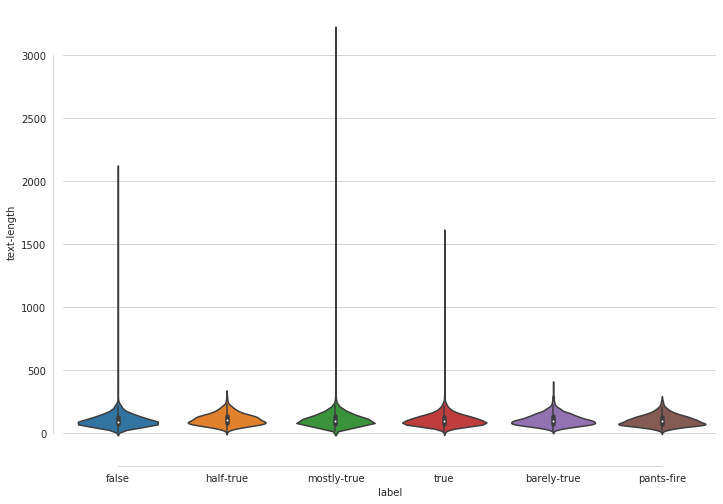

In [172]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(x='label', y='text-length', data=train_data)
sns.despine(offset=10, trim=True);

In [173]:
train_data.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,text-length
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10240.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407,106.918750
std,18.973764,24.112936,35.846511,36.151688,16.128927,59.917722
min,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,99.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000,132.250000
max,70.000000,114.000000,160.000000,163.000000,105.000000,3192.000000


In [174]:
labels = train_data.groupby('label').mean()
labels.corr()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,text-length
barely_true_counts,1.000000,-0.127664,0.305618,0.283077,-0.348281,0.520355
false_counts,-0.127664,1.000000,-0.823283,-0.851132,0.925060,-0.731996
half_true_counts,0.305618,-0.823283,1.000000,0.983699,-0.851951,0.740105
mostly_true_counts,0.283077,-0.851132,0.983699,1.000000,-0.875937,0.696002
pants_on_fire_counts,-0.348281,0.925060,-0.851951,-0.875937,1.000000,-0.645328
text-length,0.520355,-0.731996,0.740105,0.696002,-0.645328,1.000000


### Feature selection or attribute evaluator consists of identifying the relevant features and ignoring the irrelevant ones from a dataset. The use of attribute evaluator methods enhances the performance of machine learning algorithms. Visualizing Correlation heatmap helps in better correlation-based feature selection

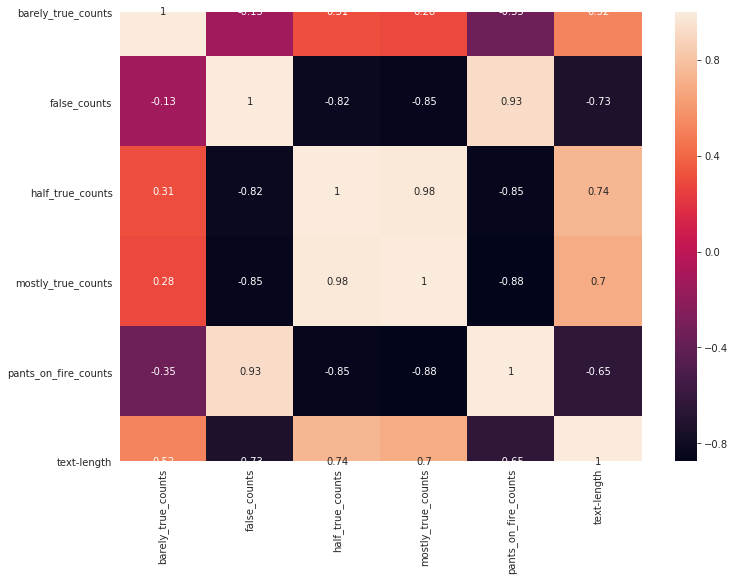

In [175]:
from matplotlib import pyplot
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax,data=labels.corr(), annot=True)


* Looking at the map, false is strongly correlated with pants_on_fire, and mostly_true seems strongly correlated with half_true. There is also a negative correlation between false_counts and the other features.

### Visualizing mostly used words corresponding to True, False, barely-true, mostly-true, half-true, pants-fire labels

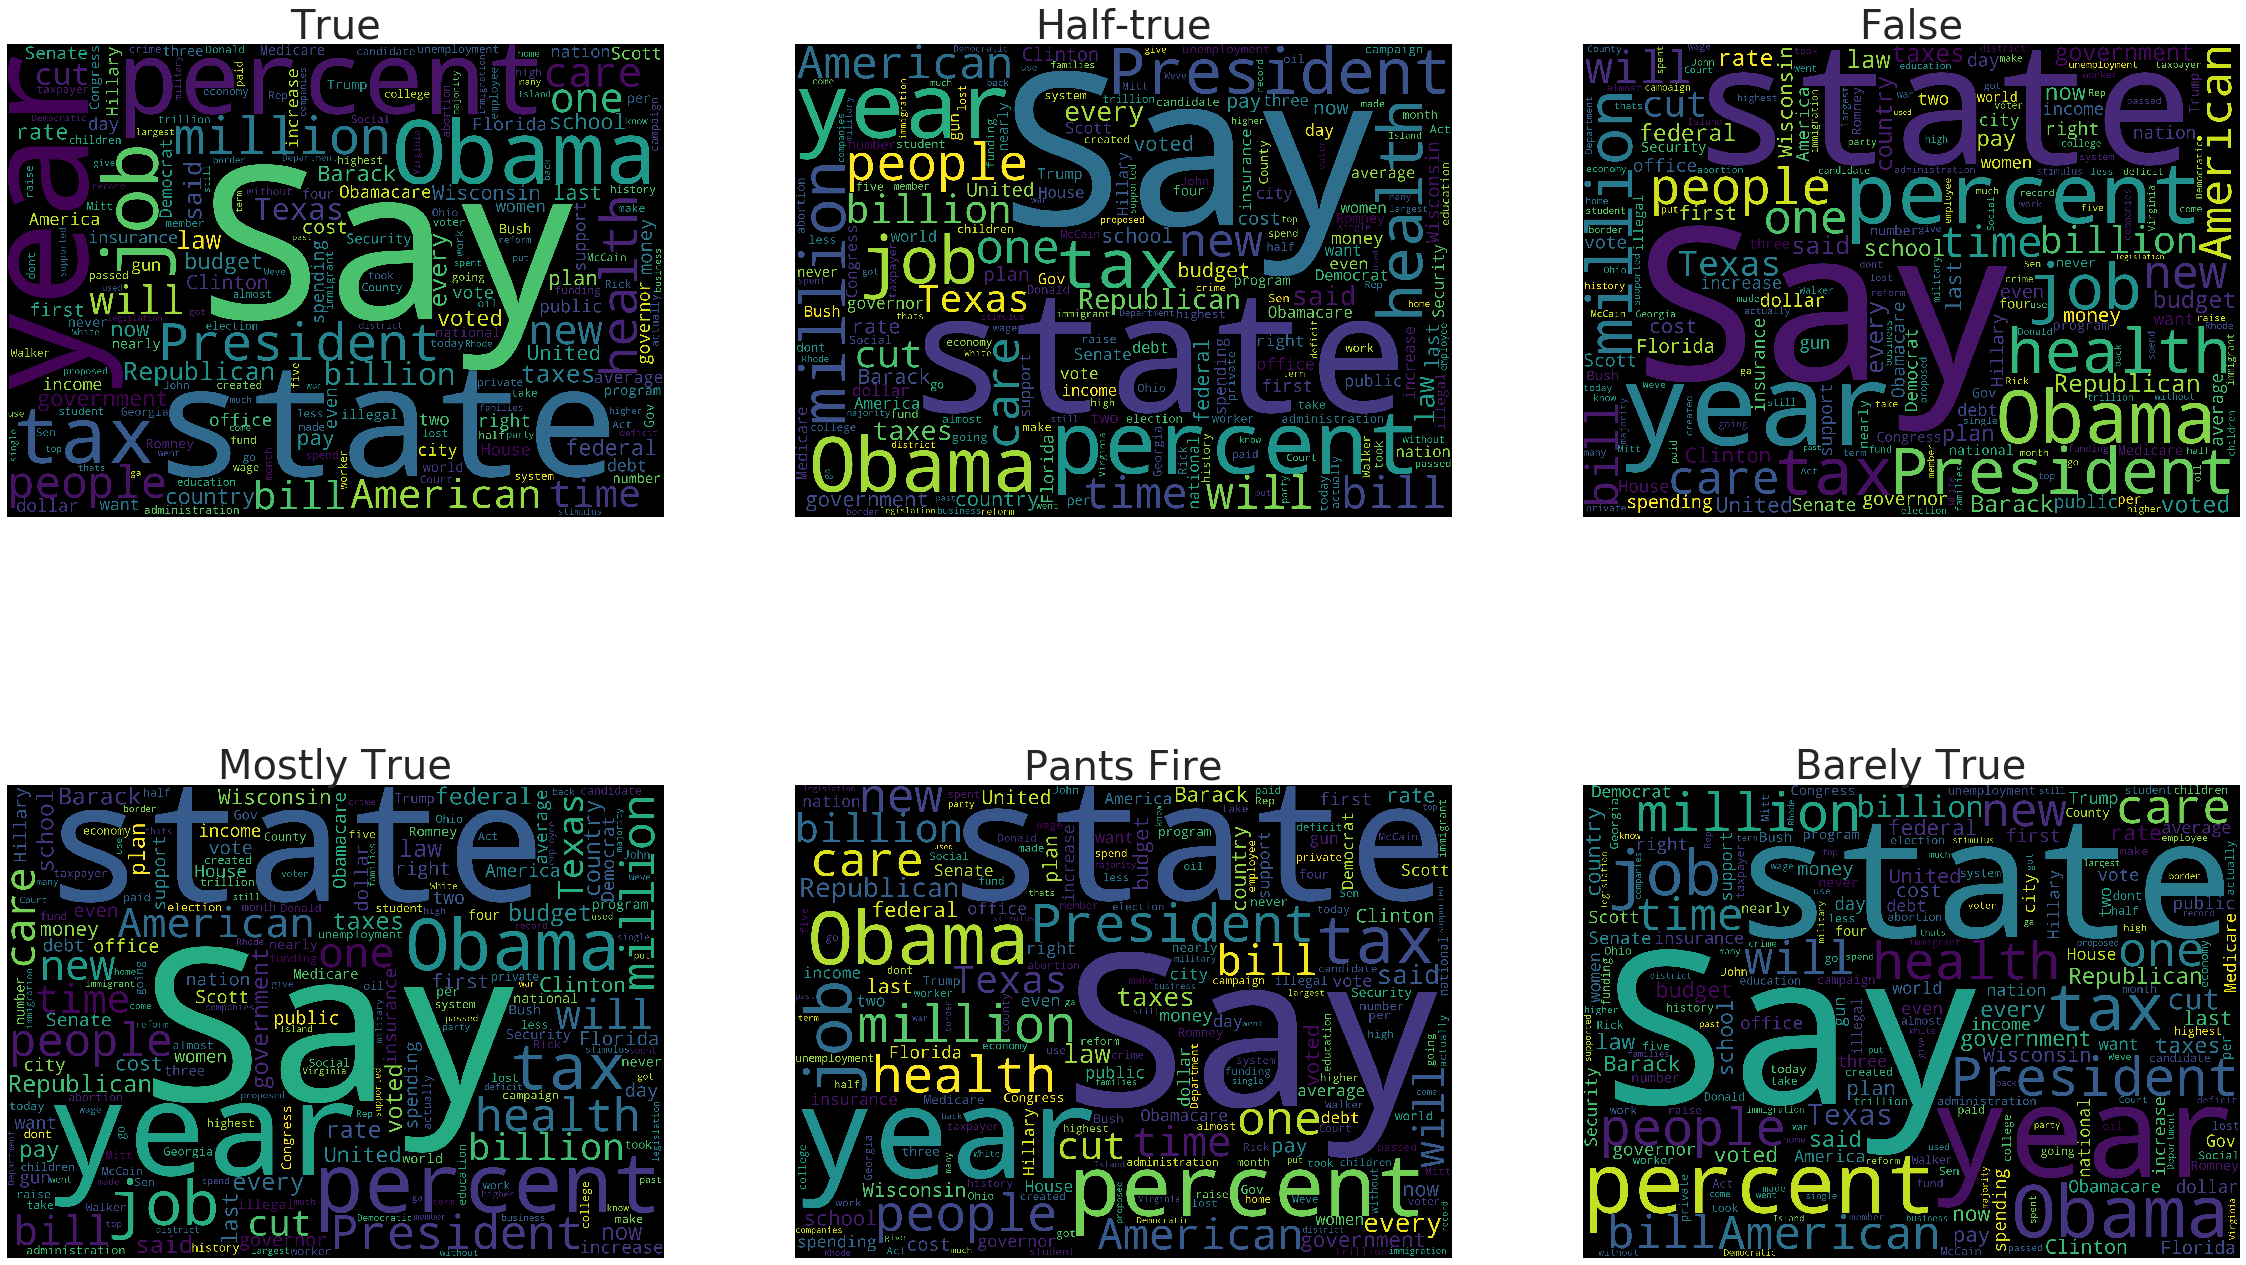

In [176]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# true
subset = train_data[train_data.label==True]
text = train_data['statement']
cloud_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))


plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("True",fontsize=40)
plt.imshow(cloud_true)

# true
subset = train_data[train_data.label=='half-true']
text = train_data['statement']
cloud_half_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Half-true",fontsize=40)
plt.imshow(cloud_half_true)



# false
subset = train_data[train_data.label=='false']
text = train_data['statement']
cloud_false = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("False",fontsize=40)
plt.imshow(cloud_false)



# mostly-true
subset = train_data[train_data.label=='mostly-true']
text = train_data['statement']
cloud_mostly_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Mostly True",fontsize=40)
plt.imshow(cloud_mostly_true)

#pants-fire
subset = train_data[train_data.label=='pants-fire']
text = train_data['statement']
cloud_pants_fire = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Pants Fire",fontsize=40)
plt.imshow(cloud_pants_fire)


#barely-true
subset = train_data[train_data.label=='barely-true']
text = train_data['statement']
cloud_barely_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Barely True",fontsize=40)
plt.imshow(cloud_barely_true)

### An important set of metrics in text mining relates to the frequency of words or token in a certain corpus of text documents. 
* Following is the frequency distribution (list) of most frequently used words among the statements in traning data set

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


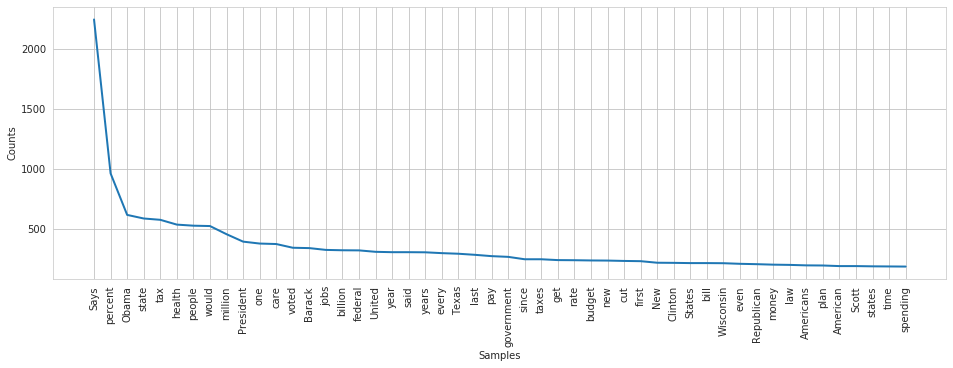

In [177]:
from collections import defaultdict
from nltk.corpus import stopwords
import pandas as pd
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')


word_list=[]
word_freq = defaultdict(int)

for text in train_data.statement:
    for word in text.split():
        if word.lower() not in stop_words and word.isalpha():
            word_list.append(word)
            word_freq[word] += 1

pd.DataFrame.from_dict(word_freq, orient='index') \
.sort_values(0, ascending=False) \
.rename(columns={0: 'abs_freq'})

freqdist = nltk.FreqDist(word_list)
plt.figure(figsize=(16,5))
freqdist.plot(50)


* The words 'Says','percent','Obama' are frequently used

## Forming Vocabulary of Controversial words

 * Using a four-point scale to classify 200 high-frequency terms analysed from 
   * https://wpcurve.com/words-that-trigger-emotional-responses/
   * https://www.scribd.com/doc/82701103/Analyst-Desktop-Binder-REDACTED
   * https://arxiv.org/pdf/1409.8152.pdf

Indicate based on threshold if sentence is -
* Strongly Controversial: 
* Somewhat Controversial:
* Less Controversial
* Non-Controversial: 

In [0]:
vocab_doc = ["abuse administration afghanistan aid america american army attack attacks authorities authority ban banks benefits bill border budget campaign candidate candidates catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"]

### To further analyze our dataset, we need to transform each article's text to a feature vector or word embedding


# Data pre-processing 
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem


### Categorize label column

In [0]:
train_data['label_id'] = train_data['label'].factorize()[0]

In [180]:
train_data.isnull().sum()

id                         0
label                      0
statement                  0
subjects                   2
speaker                    2
speaker_job             2897
state                   2208
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
text-length                0
label_id                   0
dtype: int64

In [181]:
train_data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 16 columns):
id                      10240 non-null object
label                   10240 non-null object
statement               10240 non-null object
subjects                10238 non-null object
speaker                 10238 non-null object
speaker_job             7343 non-null object
state                   8032 non-null object
party                   10238 non-null object
barely_true_counts      10238 non-null float64
false_counts            10238 non-null float64
half_true_counts        10238 non-null float64
mostly_true_counts      10238 non-null float64
pants_on_fire_counts    10238 non-null float64
context                 10138 non-null object
text-length             10240 non-null int64
label_id                10240 non-null int64
dtypes: float64(5), int64(2), object(9)
memory usage: 1.3+ MB


In [182]:
test_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             325
state                   262
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  17
dtype: int64

In [183]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
id                      1267 non-null object
label                   1267 non-null object
statement               1267 non-null object
subjects                1267 non-null object
speaker                 1267 non-null object
speaker_job             942 non-null object
state                   1005 non-null object
party                   1267 non-null object
barely_true_counts      1267 non-null int64
false_counts            1267 non-null int64
half_true_counts        1267 non-null int64
mostly_true_counts      1267 non-null int64
pants_on_fire_counts    1267 non-null int64
context                 1250 non-null object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB


In [184]:
valid_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             345
state                   279
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  12
dtype: int64

In [185]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
id                      1284 non-null object
label                   1284 non-null object
statement               1284 non-null object
subjects                1284 non-null object
speaker                 1284 non-null object
speaker_job             939 non-null object
state                   1005 non-null object
party                   1284 non-null object
barely_true_counts      1284 non-null int64
false_counts            1284 non-null int64
half_true_counts        1284 non-null int64
mostly_true_counts      1284 non-null int64
pants_on_fire_counts    1284 non-null int64
context                 1272 non-null object
dtypes: int64(5), object(9)
memory usage: 140.6+ KB


In [0]:
label_id_df = train_data[['label', 'label_id']].sort_values('label_id')
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id', 'label']].values)

In [187]:
label_to_id

{'barely-true': 4,
 'false': 0,
 'half-true': 1,
 'mostly-true': 2,
 'pants-fire': 5,
 'true': 3}

## Remove unnecessary columns

In [0]:

train_data = train_data.drop(labels = ['party','subjects','speaker','speaker_job','state','context','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts'], axis=1)

In [189]:
train_data.head()

,id,label,statement,text-length,label_id
0,2635.json,false,Says the Annies List political group supports ...,82,0
1,10540.json,half-true,When did the decline of coal start? It started...,141,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2
3,1123.json,false,Health care reform legislation is likely to ma...,78,0
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1


# Parts of speech tagging 
### Parts of speech tagging can be important for syntactic and semantic analysis, for each word in news can have several semantic meanings. 
### Identify Part of Speech Tags:
* Noun Count
* Verb Count
* Adjective Count
* Adverb Count
* Pronoun Count

In [0]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

# train_data['noun_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'noun'))
# train_data['verb_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'verb'))
# train_data['adj_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adj'))
# train_data['adv_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adv'))
# train_data['pron_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'pron'))

In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [0]:
ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

In [0]:
def processtag(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [194]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')

sent = processtag(ex)
sent

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [195]:
#modules for preprocessing the corpus by regular expressions
import re
# import textacy
!pip install textacy
# module for preprocessing the corpus by parts of speach 
import spacy 
nlp = spacy.load('en')

### Parts of Speech Cleaning

In [0]:
def clean_corpus(sentence):
    sentence = re.sub(r"\\\'", r' ', sentence)
    sentence = re.sub(r' s ', r" ", sentence)
    ## removing character sequences of Word files
    sentence = re.sub(r'(\\n|\\xe2|\\xa2|\\x80|\\x9c|\\x9c|\\x9d|\\t|\\nr|\\x93)', r' ', sentence)
    sentence = sentence.replace(r"b'", ' ') ## removing the beginning of some documents
    sentence = re.sub(r'\{[^\}]+\}', r' ', sentence) ## removing word macros

    sentence = textacy.preprocessing.replace_emails(sentence, replace_with=r' ') ## removing emails
    sentence = textacy.preprocessing.replace_urls(sentence, replace_with=r' ') ## removing urls

    sentence = re.sub(r'(#|$| [b-z] |\s[B-Z]\s|\sxxx\s|\sXXX\s|XXX\w+)', r' ', sentence)
    
    ## removing character sequences of pdf files
    sentence = re.sub(r'(\\x01|\\x0c|\\x98|\\x99|\\xa6|\\xc2|\\xa0|\\xa9|\\x82)', r' ', sentence)

    sentence = re.sub(r'(c/-d*)', r' ', sentence) #remove address
    
    sentence = re.sub(r'(\\x01|\\x0c|\\x98|\\x99|\\xa6|\\xc2|\\xa0|\\xa9|\\x82|\\xb7)', r' ', sentence)
    
    # removing trade mark of specific pdf file
    sentence = sentence.replace(r'LE G A SA L E M D PL O C E S', ' ')      
    
    # striping consecutive white spaces
    sentence = re.sub(r'\s\s+', ' ', sentence).strip()
    sentence = sentence.strip()
    return sentence

In [197]:
test_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [198]:
import textacy
from textacy import preprocessing
from textacy import preprocess
from textacy import constants
import spacy 
!pip install textacy
from textacy.vsm import Vectorizer
clean_texts = [clean_corpus(str(doc)) for doc in train_data['statement']]
test_clean_texts = [clean_corpus(str(doc)) for doc in test_data['statement']]


* Using Spacy nlp documents were instantiated to perform parts of speech cleaning

In [0]:

nlp_docs = [nlp(clean_text) for clean_text in clean_texts]
nlp_test_docs = [nlp(clean_text) for clean_text in test_clean_texts]

In [200]:

sentence = list(nlp_docs[23].sents)[0]
sentence

Says Scott Walker favors cutting up to 350,000 families and children off health care.

### Only nouns, verbs and adjectives will be kept
Entities like 'PERSON', 'NAME','GPE', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART','LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL' are removed, based on vocabulary terms.

In [0]:
tags_to_keep = ['JJ', 'NN', 'NNP', 'NNPS', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [202]:
_=[print('{} - {} - {}'.format(token, token.tag_, token.pos_)) for token in sentence]

Says - VBZ - VERB
Scott - NNP - PROPN
Walker - NNP - PROPN
favors - VBZ - VERB
cutting - VBG - VERB
up - RP - PART
to - TO - PART
350,000 - CD - NUM
families - NNS - NOUN
and - CC - CCONJ
children - NNS - NOUN
off - IN - ADP
health - NN - NOUN
care - NN - NOUN
. - . - PUNCT


In [203]:
_=[print('{} - {} - {} - {}'.format(token, token.tag_, token.pos_, token.lemma_))
   for token in sentence if token.tag_ in tags_to_keep]

Says - VBZ - VERB - say
Scott - NNP - PROPN - Scott
Walker - NNP - PROPN - Walker
favors - VBZ - VERB - favor
cutting - VBG - VERB - cut
families - NNS - NOUN - family
children - NNS - NOUN - child
health - NN - NOUN - health
care - NN - NOUN - care


In [0]:
# entities_to_remove = ['PERSON', 'NAME','GPE', 'LOC', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART',
#                       'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

entities_to_remove = ['PERSON', 'NAME','GPE', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART',
                      'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

In [0]:

filtered_texts = []
for doc in nlp_docs:
    filtered_text = ''
    for sentence in doc.sents:
        sent_filt_text = ' '.join([token.lemma_ 
                                   for token in sentence if (token.tag_ in tags_to_keep 
                                                             and not token.is_stop
                                                             and not token.ent_type_ in entities_to_remove
                                                            )])
        filtered_text = filtered_text + ' ' + sent_filt_text
    filtered_texts.append(filtered_text)

In [0]:

test_filtered_texts = []
for doc in nlp_test_docs:
    filtered_text = ''
    for sentence in doc.sents:
        sent_filt_text = ' '.join([token.lemma_ 
                                   for token in sentence if (token.tag_ in tags_to_keep 
                                                             and not token.is_stop
                                                             and not token.ent_type_ in entities_to_remove
                                                            )])
        filtered_text = filtered_text + ' ' + sent_filt_text
    test_filtered_texts.append(filtered_text)

In [0]:
filtered_texts = [clean_corpus(str(doc)) for doc in filtered_texts]

In [0]:
test_filtered_texts = [clean_corpus(str(doc)) for doc in test_filtered_texts]

In [209]:

print(clean_texts[7], '\n\n', filtered_texts[7])

I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate. 

 person stage work pass ethic reform


In [0]:
train_data['filtered_text']= filtered_texts
test_data['filtered_text']= test_filtered_texts

In [211]:
test_data[['statement','filtered_text']][:10]

,statement,filtered_text
0,Building a wall on the U.S.-Mexico border will...,build wall U.S.-Mexico border
1,Wisconsin is on pace to double the number of l...,pace double number layoff
2,Says John McCain has done nothing to help the ...,say help vet
3,Suzanne Bonamici supports a plan that will cut...,support plan cut choice Medicare Advantage senior
4,When asked by a reporter whether hes at the ce...,ask reporter center criminal scheme violate ca...
5,Over the past five years the federal governmen...,federal government pay retirement disability b...
6,Says that Tennessee law requires that schools ...,say law require school receive proceed year in...
7,"Says Vice President Joe Biden ""admits that the...",say Vice President admit people scamme economi...
8,Donald Trump is against marriage equality. He ...,marriage equality want
9,We know that more than half of Hillary Clinton...,know meeting secretary state give major contri...


## Apply Stemming , Lemmatization and remove Stopwords and special characters from News Statement column
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem

In [212]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
#pre-processing
import re 

def preprocess(raw_news):
    import nltk    
    news = re.sub("[^a-zA-Z]", " ", raw_news) 
    news = re.sub(r"\"", "", news) 
    news = re.sub(r"\'", "", news) 
    news = re.sub(r"[0-9]", "digit", news)
    news =  news.lower()     
    news_words = nltk.word_tokenize( news)        
    stops = set(nltk.corpus.stopwords.words("english"))       
    words = [w for w in  news_words  if not w in stops]        
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]     
    return " ".join(stems)


import re
train_data['stemmed'] = train_data["filtered_text"].apply(preprocess) 
test_data['stemmed'] = test_data["filtered_text"].apply(preprocess) 
#testing['statement'] = testing["statement"].apply(cleaning)
print(len(train_data), "statements")
#print(len(testing), "statements")

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def lemmatize(self, word, pos=wn.NOUN):
    lemmas = wordnet._morphy(word, pos)
    return min(lemmas, key=len) if lemmas else word


from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r"[0-9]", "digit", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)   
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
10240 statements


In [213]:

import time
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub(r"[0-9]", "digit", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))
# clean text and title and create new column "tokenized"
t1 = time.time()
train_data['tokenized'] = train_data['stemmed'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(train_data), "articles:", (t2-t1)/60, "min")


Time to clean and tokenize 10240 articles: 0.04802838166554769 min


In [0]:
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [0]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
 

In [216]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime..."
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]"
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f..."
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]"


### Tokenize the Controversy vocab document

In [217]:
# tokenize

texts = ([list(set([stemmer.stem(word) for word in vocab_doc[0].split()]))])
print(texts)


[['lawmak', 'progress', 'unemploy', 'inaccuraci', 'russian', 'spend', 'nation', 'american', 'leadership', 'vote', 'societi', 'administr', 'egypt', 'kill', 'usa', 'debat', 'price', 'war', 'marriag', 'invest', 'health', 'rate', 'oklahoma', 'ban', 'store', 'charg', 'democrat', 'republican', 'chines', 'violenc', 'legisl', 'conserv', 'forc', 'restrict', 'crimin', 'citi', 'number', 'congress', 'trial', 'washington', 'benefit', 'germani', 'polit', 'china', 'power', 'offens', 'threat', 'sex', 'enforc', 'chairman', 'compani', 'tax', 'shoot', 'strike', 'reform', 'abus', 'support', 'lawsuit', 'educ', 'presid', 'bank', 'campaign', 'peac', 'author', 'drug', 'comment', 'shot', 'india', 'ga', 'israel', 'control', 'concern', 'fiscal', 'america', 'border', 'weapon', 'credit', 'popul', 'sourc', 'cathol', 'strategi', 'aid', 'cost', 'primari', 'debt', 'korea', 'justic', 'sector', 'stock', 'inform', 'govern', 'diseas', 'murder', 'labor', 'goal', 'countri', 'law', 'media', 'mexico', 'secur', 'world', 'polic

### Create a dictionary of Controversial vocabulary words
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, the texts are converted to a more manageable representation.

One way of extracting features from text is to use the bag of words model: a model where for each document, containing the controversial terms, the presence and  frequency of words is taken into consideration, but the order in which they occur is ignored.

In [218]:
import gensim
dictionary = gensim.corpora.Dictionary(texts)

dictionary.save('/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/vocab_list.dict')
print(dictionary[5])
print(dictionary.token2id['expect'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


aid
58


In [219]:
print(dictionary)

Dictionary(170 unique tokens: ['abus', 'account', 'administr', 'advantag', 'afghanistan']...)


In [220]:
print(dictionary.token2id)

{'abus': 0, 'account': 1, 'administr': 2, 'advantag': 3, 'afghanistan': 4, 'aid': 5, 'america': 6, 'american': 7, 'amount': 8, 'armi': 9, 'attack': 10, 'attorney': 11, 'author': 12, 'ban': 13, 'bank': 14, 'benefit': 15, 'bill': 16, 'border': 17, 'budget': 18, 'campaign': 19, 'candid': 20, 'cathol': 21, 'chairman': 22, 'charg': 23, 'china': 24, 'chines': 25, 'church': 26, 'citi': 27, 'class': 28, 'comment': 29, 'compani': 30, 'concern': 31, 'congress': 32, 'conserv': 33, 'control': 34, 'cost': 35, 'countri': 36, 'court': 37, 'credit': 38, 'crime': 39, 'crimin': 40, 'crisi': 41, 'cut': 42, 'debat': 43, 'debt': 44, 'defens': 45, 'deficit': 46, 'delay': 47, 'democrat': 48, 'diseas': 49, 'dollar': 50, 'drug': 51, 'economi': 52, 'educ': 53, 'effect': 54, 'egypt': 55, 'elect': 56, 'enforc': 57, 'expect': 58, 'famili': 59, 'februari': 60, 'fight': 61, 'financ': 62, 'fiscal': 63, 'forc': 64, 'fund': 65, 'ga': 66, 'germani': 67, 'goal': 68, 'govern': 69, 'gun': 70, 'health': 71, 'hous': 72, 'imm

In [221]:
new_doc = "credit budget violenc"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)

[(18, 1), (38, 1), (161, 1)]


#### Create doc2bow() of the tokenized texts, to count the number of occurences of each distinct word, and convert the word to its integer word id and returns the result as a sparse vector
* store the serialized corpus in memory

In [222]:
corpus = [dictionary.doc2bow(text) for text in texts]
gensim.corpora.MmCorpus.serialize('/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/vocab_list.mm', corpus) 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [223]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

### Load dictionary and corpus

In [224]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary.load('/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/vocab_list.dict')
corpus = corpora.MmCorpus('/content/drive/My Drive/AlternusVeraDataSets2019/Transformers/Amrutha/Controversy_Speaker_Factors/Datasets/vocab_list.mm')
print(corpus)

MmCorpus(1 documents, 170 features, 170 non-zero entries)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Distillation Process


## Emotion polarity-based controversy detection
* Editors use more sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. 
* The algorithm to train the emotion polarity classifier (EP), using both the annotations and sentiment measures.
* Useful in analysing the degree of controversy


# 1. Sentiment Analysis using nltk Vader

In [0]:
testing = train_data['statement']

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [227]:
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Computing Polarity of each sentence in training data set using Vader

In [228]:
count=0
for x in testing:
    if count<3:
        print(x)
        ss = sid.polarity_scores(x)
        for k in sorted(ss):
            print("{0}:{1},".format (k, ss[k]), end ="\n\n")
            print
    count+=1
    

Says the Annies List political group supports third-trimester abortions on demand.
compound:0.25,

neg:0.115,

neu:0.692,

pos:0.192,

When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
compound:0.3612,

neg:0.0,

neu:0.902,

pos:0.098,

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
compound:0.3182,

neg:0.107,

neu:0.687,

pos:0.206,



### Appending polarity values to the new  column 'sentiment_polarity' in traning dataset

In [229]:

sentiment_polarity = [] 
senti = []
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()
# this step will return an error if you have not installed the lexicon
summary = {"positive":0,"neutral":0,"negative":0}
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    ss['statement'] = x
    senti.append(ss)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
        sentiment_polarity.append("neutral")
        
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
        sentiment_polarity.append("positive")
     
    else:
        summary["negative"] +=1
        sentiment_polarity.append("negative")
        
print(summary)
train_data['sentiment_polarity'] = sentiment_polarity

{'positive': 3350, 'neutral': 3488, 'negative': 3402}


In [230]:
senti_df = pd.DataFrame(senti)
senti_df.head()

,neg,neu,pos,compound,statement
0,0.115,0.692,0.192,0.2500,Says the Annies List political group supports ...
1,0.000,0.902,0.098,0.3612,When did the decline of coal start? It started...
2,0.107,0.687,0.206,0.3182,"Hillary Clinton agrees with John McCain ""by vo..."
3,0.000,0.606,0.394,0.7579,Health care reform legislation is likely to ma...
4,0.000,1.000,0.000,0.0000,The economic turnaround started at the end of ...


### Variance min and max range for Controversy detection
* While it is not possible to say that controversial topics are more positive or negative than noncontroversial ones.
* we can analyse the degree by calculating their variance. 
* Controversial topics have a higher variance than non-controversial ones. 
* Controversial ones have a variance of at least 2, while non-controversial ones have a variance of at most 1.5.



In [231]:
senti_df['variance']= abs(senti_df['pos'] - senti_df['neg'])
print(senti_df['variance'].max())
print(senti_df['variance'].min())
senti_df 
label = []

for variance in senti_df['variance']:
    
    if variance > 0.7:
        label.append(3) ## strongly-controversial
    elif 0.5<variance < 0.7:
        label.append(2)   ## somewhat-controversial
    elif 0.2<variance<0.5:
         label.append(1) ## weakly- controversial
    elif variance < 0.2:
         label.append(0) ## non- controversial

senti_df.head()

0.796
0.0


,neg,neu,pos,compound,statement,variance
0,0.115,0.692,0.192,0.2500,Says the Annies List political group supports ...,0.077
1,0.000,0.902,0.098,0.3612,When did the decline of coal start? It started...,0.098
2,0.107,0.687,0.206,0.3182,"Hillary Clinton agrees with John McCain ""by vo...",0.099
3,0.000,0.606,0.394,0.7579,Health care reform legislation is likely to ma...,0.394
4,0.000,1.000,0.000,0.0000,The economic turnaround started at the end of ...,0.000


## Enrich the dataset - Add variance as a column from above dataframe

In [0]:
train_data['variance_level']= senti_df['variance']

In [233]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000


## WordCloud Visualization of positive and negative words

Highly Positive named entities


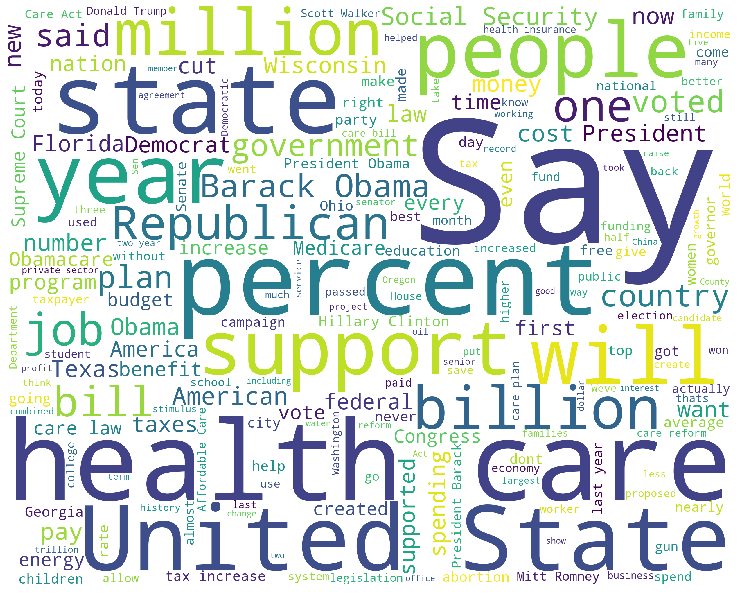

Highly Negative Named Entities


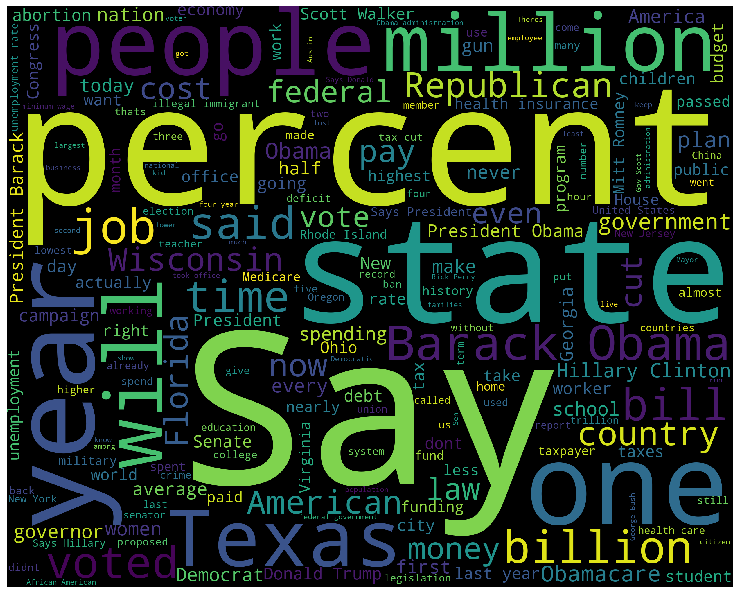

In [234]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
positive_words=[] 
negative_words=[]
print("Highly Positive named entities")
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    if ss["compound"] > 0.0:
        positive_words.append(x)
    else:
        negative_words.append(x)
        
wordcloud_draw(positive_words,'white')
print("Highly Negative Named Entities")
wordcloud_draw(negative_words)

# 2. Topic Modelling


#  1) Latent Semantic Analysis -
## Analyse Controversy Influence factor using Latent Semantic Analysis
* Compute possible similarities based on apparent semantic relatedness of texts (words)
* Using “Indexing by Latent Semantic Analysis” 
* Use LSA to compare documents based on their topics.

### Create the transformation model for corpus using tfidf

In [235]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)
print(lsi)

LsiModel(num_terms=170, num_topics=2, decay=1.0, chunksize=20000)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [236]:
lsi.print_topics(10)

[(0,
  '0.077*"advantag" + 0.077*"america" + 0.077*"worth" + 0.077*"world" + 0.077*"countri" + 0.077*"credit" + 0.077*"washington" + 0.077*"whether" + 0.077*"bank" + 0.077*"victim"')]

In [237]:
doc1 = "Human politics russian banks"
vec_bow1 = dictionary.doc2bow(doc1.lower().split())
#print(vec_bow1)
vec_lsi1 = lsi[vec_bow1] # convert the query to LSI space
print(vec_lsi1[0][1]) #LSI index



0.07669649888473705


## Similarity score

In [238]:
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[vec_lsi1]
print(list(enumerate(sims)))

[(0, 1.0)]


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
voc="obama law advantag charg diseas control syria comment inform rate attorney inaccuraci polic poll compani author rais senat iran oil dollar marriag india leadershi shoot reform defens republican delay union bank church presid peac offici februari fiscal fight spend parent candid fund school chines number expect rule ban job oklahoma amount campaign egypt prison educ tax administr concern vote cost violenc kill korea germani statu media race voter american insur effect popul attack drug debt world invest chairman trial congress murder crisi economi israel health war shot russian govern offens lawmak support sex patient gun whether progress judg democrat class mexico strike forc countri cut parti stock polit aid cathol crimin financ sourc store famili secur washington benefit elect threat reason unemploy weapon sale border bill debat land usa money nation investig price restrict court enforc conserv afghanistan immigr legisl goal abus syrian justic lawsuit armi victim china crime primari power account hous citi strategi societi labor project worth russia polici deficit militari america market sector budget credit news"

voc_bow = dictionary.doc2bow(voc.lower().split())
vec_lsa_voc = lsi[voc_bow]

In [0]:
LSA1_score=[]
for doc in train_data['stemmed']:
    bow_vector_st = dictionary.doc2bow(doc.lower().split())
    vec_lsa_ex = lsi[bow_vector_st]
    sim = gensim.matutils.cossim(vec_lsa_voc, vec_lsa_ex)

### Computing LSA MatrixSimilarity index for all news statements in training dataset with the dictionary of Controversial words

In [241]:
LSA_score=[]
mydict={}

for data in train_data['stemmed']:
    vec_bow2 = dictionary.doc2bow(data.lower().split())
    vec_lsi2 = lsi[vec_bow2] # convert the query to LSI space
    mydict[data] = vec_lsi2
    if len(vec_lsi2) >= 1:
        sim = gensim.matutils.cossim(vec_lsa_voc, vec_lsa_ex)
        LSA_score.append(vec_lsi2[0][1])
    else:
        LSA_score.append(0)
       
       
sorted_mydict = OrderedDict(sorted(mydict.items(), key=lambda x: x[1], reverse=True))
count=0
for key,val in sorted_mydict.items():
    if val and (count > 3 and count < 10):
        print (key, "=>", val[0][1])
        print('\n')
    count+=1

    

spend money health care capita countri world develop countri world spend time averag countri spend capita spend => 0.8436614877321085


fact presid oppos abort abort go abort barack obama presid tv interview megachurch pastor true job lose lose econom polici place effect economi job accomplish job stimulus barack obama presid interview => 0.8436614877321074


say vote war unpaid vote tax cut unpaid vote prescript drug bill cost health care bill pay => 0.843661487732107


presid elect trump immigr polici similar polici sit senat hous suspend immigr countri harbor terror suspend immigr vet => 0.7669649888473703


veto spend lawmak cut taxi small busi job creation nation hous market right balanc state budget cut state spend => 0.7669649888473701


schoolchildren nation forc watch presid justifi plan govern run health care bank automobil compani increas taxi creat job rack debt presid => 0.7669649888473699




## Enrich the dataset - Append the LSA_score as a new column to the training dataset 

In [0]:
train_data['LSA_controversy_score']= LSA_score

In [243]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077,0.153393
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098,0.153393
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099,0.153393
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394,0.306786
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000,0.000000


### The scores are not very accurate, as some sentences which are controversial have still been scored low

# 2) TfidfVectorizer
### Analyse Controversy Influence factor using Tfidf Cosine Similarity
* Compute Cosine Similarity between statements and controversy vocabulary

In [0]:
corpus_cos = []
import gensim
from nltk.tokenize import word_tokenize

for text in train_data['stemmed']:
    corpus_cos.append(text)

In [0]:
vocab_doc_str = "abuse administration afghanistan aid america american army attacks authorities ban banks benefits bill border budget campaign candidate catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"

In [0]:
vocab_doc_stem = "abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store strategi strike support syria syrian tax threat trial unemploy union usa victim violenc vote voter war washington weapon whether world worth"

In [0]:
corpus_cos.append(vocab_doc_stem)

#### Vectorize using TfidfVectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [249]:
X = vectorizer.fit_transform(corpus_cos)
X
print(X[10])

  (0, 3068)	0.7242013105222024
  (0, 3900)	0.3242086344365543
  (0, 3355)	0.20126675454725135
  (0, 4669)	0.3225092976715584
  (0, 2395)	0.24664291836049332
  (0, 5272)	0.1941172480633918
  (0, 5645)	0.3569123624239409


In [250]:
features = vectorizer.get_feature_names()
print(features[4133])

radius


In [251]:
X.shape

(10241, 5851)

In [252]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
from scipy import spatial

In [254]:
cos_doc1 = 1 - spatial.distance.cosine(X[123].toarray(), X[10240].toarray())
cos_doc1

0.029974000005551504

## Computing Cosine Similarity for all News statements
* cosine distance = 1 - cosine similarity

In [255]:
cosine_dict={}
count = 0
controversy_score=[]
#controversy_label= []
for i in range(10240):
    cos_doc1 = 1- spatial.distance.cosine(X[i].toarray(), X[10240].toarray())
    cosine_dict[train_data['statement'][i]] = cos_doc1
    controversy_score.append(cos_doc1)
        
    
sorted_dict = OrderedDict(sorted(cosine_dict.items(), key=lambda x: x[1]))

for key,val in sorted_dict.items():
    if val and (count > 3 and count < 1697):
        print (key, "=>", val)
        print('\n')
    count+=1


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## Enrich the dataset -  Append the  cosine_similarity_score as a new column to the training dataset 

In [0]:
train_data['cosine_similarity_tfidf']= controversy_score

In [257]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score,cosine_similarity_tfidf
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077,0.153393,0.032854
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098,0.153393,0.019089
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099,0.153393,0.042025
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394,0.306786,0.069592
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000,0.000000,0.000000


* cosine distance of 0; documents are similar;  cosine distance 1, documents are dissimilar
##### The scores are very inaccurate , since our dictionary consists of Controversy words combined into  one set of documents. It is not able to find frequency and important of each word, and most of the terms have zero as value.

# 3) LDA (Latent Dirichlet Allocation)
## Building LDA model using Bag of Words on the Data set
* Create a dictionary from ‘vocabulary’ containing the number of times a word appears in the training set.
* LDA returns a vector of topic probabilities for each document.


#### Get word frequency using nltk to get a word frequency (by count)  and  keep the top most used words to train the LDA model 

In [258]:
import nltk
from nltk import FreqDist
# first get a list of all words
all_words = [word for item in list(train_data['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words
#all_words

5799

In [259]:
# choose k and visually inspect the bottom 10 words of the top k
k = 1800
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('appl', 5),
 ('fighter', 5),
 ('perfect', 5),
 ('exon', 5),
 ('rhode', 5),
 ('expenditur', 5),
 ('crop', 5),
 ('interst', 5),
 ('northeast', 5),
 ('affili', 5)]

In [260]:
# choose k and visually inspect the bottom 10 words of the top k
k =1900
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('ordin', 5),
 ('due', 5),
 ('hca', 5),
 ('transact', 5),
 ('seiz', 5),
 ('legitim', 5),
 ('baseb', 5),
 ('scientif', 5),
 ('deep', 5),
 ('purpo', 5)]

In [0]:
# define a function only to keep words in the top k words
k=5
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [262]:
top_k_words

{'presid', 'say', 'state', 'tax', 'vote'}

In [263]:
# document length
train_data['doc_len'] = train_data['tokenized'].apply(lambda x: len(x))
doc_lengths = list(train_data['doc_len'])
train_data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 10240 
average document length 7.322265625 
minimum document length 0 
maximum document length 249


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


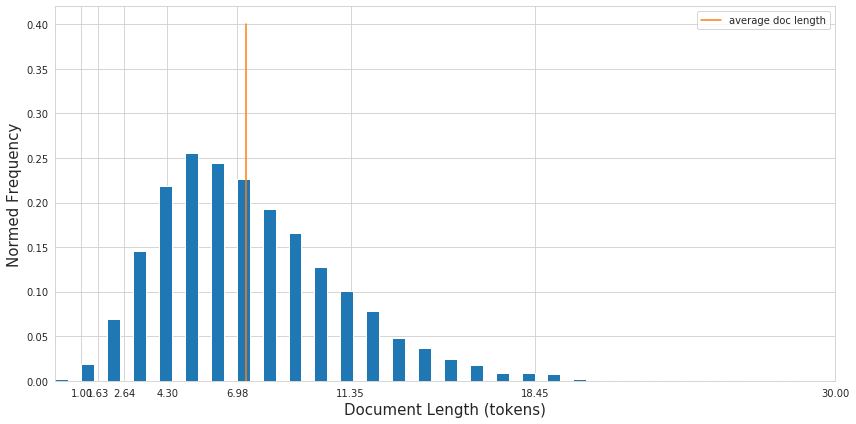

In [264]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(1),stop=np.log10(30),num=8, base=10.0))
plt.xlim(0,30)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.4,9)], np.linspace(0.0,0.4,9), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

###  It is useful to get the document length distribution to understand which model to choose. 
* For applying LDA it is advised to drop short articles as LDA does not work very well on short documents, so I will drop some of the shorter articles before training the model.



In [0]:
texts= list(texts)
#texts

In [266]:

dict_tokenized = gensim.corpora.Dictionary(texts)
count = 0
for k, v in dict_tokenized.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abus
1 account
2 administr
3 advantag
4 afghanistan
5 aid
6 america
7 american
8 amount
9 armi
10 attack


### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’

In [0]:
dict_bow_corpus = [dict_tokenized.doc2bow(doc) for doc in texts]
#dict_bow_corpus[0]


## Training LDA model using gensim.models.LdaMulticore for statements in training dataset

In [0]:
lda_model = gensim.models.LdaMulticore(dict_bow_corpus, num_topics=10, id2word=dict_tokenized, passes=2, workers=2)

In [269]:
index = similarities.MatrixSimilarity(lda_model[dict_bow_corpus])
index

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
voc_bow = dictionary.doc2bow(vocab_doc_stem.lower().split())
vec_lda_voc = lda_model[voc_bow]

In [271]:
print(train_data['tokenized'][5])

['bear', 'start', 'quarterback', 'total', 'number', 'tenur', 'uw', 'faculti', 'fire']


In [0]:
from gensim import corpora, models
np.random.seed(2017)
texts_token = train_data['tokenized'].values
dictionary_tmp = corpora.Dictionary(texts_token)
corpus_tmp = [dictionary_tmp.doc2bow(text) for text in texts_token]
ldamodel2 = models.ldamodel.LdaModel(corpus_tmp, id2word=dictionary_tmp, 
                                    num_topics=8, passes=5, minimum_probability=0)

In [0]:
hm = np.array([[y for (x,y) in ldamodel2[corpus_tmp[i]]] for i in range(len(corpus_tmp))])

In [0]:
from sklearn.manifold import TSNE

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

In [0]:

tsne = TSNE(random_state=2017, perplexity=30)
tsne_embedding = tsne.fit_transform(hm)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding['hue'] = hm.argmax(axis=1)

#### For visualizing the scatter ratio of each word in the dictionary

In [0]:
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in tsne_embedding.hue],
            title = train_data.label,
            year = train_data['text-length'],
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.trigger('change');
""")

slider = Slider(start=train_data['text-length'].min(), end=train_data['text-length'].max(), value=100, step=1, title="length")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)

In [277]:
show(layout)

### The topics appear well scattered, unlike the topics for LSA model. Hence this is a better model for finding Controversy similarity index

### For each topic, LDA displays the words occuring in that topic and its relative weight.





In [278]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"world" + 0.006*"financ" + 0.006*"investig" + 0.006*"chairman" + 0.006*"candid" + 0.006*"unemploy" + 0.006*"restrict" + 0.006*"washington" + 0.006*"india" + 0.006*"democrat"
Topic: 1 
Words: 0.006*"whether" + 0.006*"senat" + 0.006*"author" + 0.006*"insur" + 0.006*"polit" + 0.006*"job" + 0.006*"war" + 0.006*"financ" + 0.006*"bank" + 0.006*"congress"
Topic: 2 
Words: 0.007*"chairman" + 0.007*"armi" + 0.007*"america" + 0.007*"account" + 0.007*"legisl" + 0.007*"murder" + 0.006*"fiscal" + 0.006*"societi" + 0.006*"tax" + 0.006*"leadership"
Topic: 3 
Words: 0.007*"strike" + 0.007*"primari" + 0.007*"cathol" + 0.006*"effect" + 0.006*"america" + 0.006*"project" + 0.006*"weapon" + 0.006*"cost" + 0.006*"elect" + 0.006*"charg"
Topic: 4 
Words: 0.007*"korea" + 0.006*"land" + 0.006*"famili" + 0.006*"attorney" + 0.006*"cost" + 0.006*"rule" + 0.006*"expect" + 0.006*"mexico" + 0.006*"labor" + 0.006*"shot"
Topic: 5 
Words: 0.007*"drug" + 0.006*"reason" + 0.006*"land" + 0.006*"disea

## 4) Running LDA using TF-IDF
* Create tf-idf model object using models.TfidfModel on ‘bow_corpus’.
* Apply transformation to the entire corpus. 


In [279]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    s += len(i)
print(s)

TfidfModel(num_docs=1, num_nnz=170)
170


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [280]:
corpus_tfidf = tf_idf[corpus]
print(corpus_tfidf)

In [281]:
corpus_tfidf

In [282]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dict_tokenized, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 1 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 2 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 3 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 4 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 5 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:804: RuntimeWarning: invalid value encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


### Performance evaluation of LDA model for classifying sample document using Bag of Words

In [283]:
for index, score in sorted(lda_model[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9947368502616882	 
Topic: 0.006*"goal" + 0.006*"border" + 0.006*"prison" + 0.006*"countri" + 0.006*"februari" + 0.006*"offici" + 0.006*"presid" + 0.006*"rule" + 0.006*"lawsuit" + 0.006*"lawmak"


### Performance evaluation of LDA model on tfidf for classifying sample document

In [284]:
for index, score in sorted(lda_model_tfidf[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.15390755236148834	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.13754841685295105	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.11282297968864441	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.10878756642341614	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.09258492290973663	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.091981254518032

In [285]:
total_topics = 50
lda_model_tfidf = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=total_topics, 
                                  passes=1, random_state=47)
lda_model_bow = models.LdaModel(corpus=dict_bow_corpus, id2word=dictionary, num_topics=total_topics,
                                passes=1, random_state=47)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [286]:
# import pyLDAvis
!pip install pyLDAvis
import pyLDAvis.gensim
data = pyLDAvis.gensim.prepare(lda_model_bow, dict_bow_corpus, dictionary)
#data[:5]

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Performance of LDA without TF-idf is better than LDA with TF-idf

## Testing model on unseen document

In [0]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [288]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
tmp=sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
print(tmp)


(6, 0.54999906)


## Calculate LDA similarity score for the News Statement from training dataset 

In [289]:
LDA_score=[]
count=0
for doc in train_data['stemmed']:
    bow_vector_st = dictionary.doc2bow(preprocess(doc))
    vec_lda_ex = lda_model[bow_vector_st]
    sim = gensim.matutils.cossim(vec_lda_voc, vec_lda_ex)
    LDA_score.append(sim)
    if (count > 3 and count < 10):
        print(doc,'=>',sim)
        print ('\n')
    count+=1
     
    

econom turnaround start end term => 0.3162277523623265


bear start quarterback total number tenur uw faculti fire => 0.9647635751124627


live district repres => 0.3162277523623265


person stage work pass ethic reform => 0.9647635654362097


take oregon lotteri fund port newport land new noaa marin oper center pacif => 0.9899494043990305


say gop primari oppon cast compromis vote cost electr cost => 0.9973336732834165




## Data Enrichment -  Enrich the dataset by appending LDA_score as a new column to the training dataset

In [0]:
train_data['LDA_controversy_score']= LDA_score

In [291]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score,cosine_similarity_tfidf,LDA_controversy_score
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077,0.153393,0.032854,0.989949
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098,0.153393,0.019089,0.989949
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099,0.153393,0.042025,0.989949
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394,0.306786,0.069592,0.995350
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000,0.000000,0.000000,0.316228


## Visualizing the LDA model topics using pyLDAvis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [293]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.000013  0.000020       1        1  99.473694
2     -0.000404  0.000138       2        1   0.058480
3      0.000383  0.000153       3        1   0.058480
5     -0.000001 -0.000135       4        1   0.058480
4      0.000015 -0.000223       5        1   0.058480
1     -0.000002  0.000018       6        1   0.058480
9      0.000002 -0.000038       7        1   0.058480
8      0.000012  0.000021       8        1   0.058480
0     -0.000018  0.000006       9        1   0.058480
7      0.000001  0.000041      10        1   0.058480, topic_info=    Category      Freq      Term     Total  loglift  logprob
68   Default  1.000000      goal  1.000000  30.0000  30.0000
17   Default  1.000000    border  1.000000  29.0000  29.0000
122  Default  1.000000    prison  1.000000  28.0000  28.0000
36   Default  1.000000   countri  1.000000  27.0000  27.0000
60   Default  1.000000  februari  1.000000  26.0000  26.0000
..       ...       ...       ...       ...      ...      ...
17   Topic10  0.000587    border  1.023047  -0.0195  -5.1326
124  Topic10  0.000586   project  1.005412  -0.0030  -5.1334
142  Topic10  0.000586      shot  1.009631  -0.0071  -5.1333
133  Topic10  0.000586    russia  1.006956  -0.0046  -5.1335
33   Topic10  0.000586   conserv  1.012389  -0.0102  -5.1337

[395 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         1  1.005243      account
2         1  0.992886    administr
3         1  1.001173     advantag
4         1  0.998089  afghanistan
5         1  0.988502          aid
...     ...       ...          ...
165       1  1.001925   washington
166       1  0.998453       weapon
167       1  1.005376      whether
168       1  1.002751        world
169       1  1.001970        worth

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 6, 5, 2, 10, 9, 1, 8])

### Shows the top 10 topics in LDA model for every news statements, and top terms in each topic

In [294]:
lda_model.show_topics(num_topics=5, num_words=20)

[(3,
  '0.007*"strike" + 0.007*"primari" + 0.007*"cathol" + 0.006*"effect" + 0.006*"america" + 0.006*"project" + 0.006*"weapon" + 0.006*"cost" + 0.006*"elect" + 0.006*"charg" + 0.006*"power" + 0.006*"invest" + 0.006*"amount" + 0.006*"sex" + 0.006*"campaign" + 0.006*"inform" + 0.006*"popul" + 0.006*"voter" + 0.006*"debt" + 0.006*"spend"'),
 (4,
  '0.007*"korea" + 0.006*"land" + 0.006*"famili" + 0.006*"attorney" + 0.006*"cost" + 0.006*"rule" + 0.006*"expect" + 0.006*"mexico" + 0.006*"labor" + 0.006*"shot" + 0.006*"nation" + 0.006*"china" + 0.006*"candid" + 0.006*"sourc" + 0.006*"worth" + 0.006*"comment" + 0.006*"drug" + 0.006*"polic" + 0.006*"legisl" + 0.006*"restrict"'),
 (8,
  '0.006*"bank" + 0.006*"parti" + 0.006*"forc" + 0.006*"rate" + 0.006*"administr" + 0.006*"ban" + 0.006*"attack" + 0.006*"offens" + 0.006*"attorney" + 0.006*"citi" + 0.006*"chairman" + 0.006*"news" + 0.006*"power" + 0.006*"democrat" + 0.006*"union" + 0.006*"war" + 0.006*"benefit" + 0.006*"sex" + 0.006*"statu" + 0.0

In [295]:
lda_model.show_topic(topicid=3, topn=5)

[('strike', 0.006660428),
 ('primari', 0.0065475563),
 ('cathol', 0.0065264413),
 ('effect', 0.0064962343),
 ('america', 0.006494735)]

In [0]:
text_corpus = train_data.statement.values.tolist()
text_corpus = [re.sub('\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters

In [0]:
def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus))

In [298]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
words = remove_stopwords(words)
 
print(words[1])

['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'bushs', 'administration']


In [299]:
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised
500 documents lemmatised
1000 documents lemmatised
1500 documents lemmatised
2000 documents lemmatised
2500 documents lemmatised
3000 documents lemmatised
3500 documents lemmatised
4000 documents lemmatised
4500 documents lemmatised
5000 documents lemmatised
5500 documents lemmatised
6000 documents lemmatised
6500 documents lemmatised
7000 documents lemmatised
7500 documents lemmatised
8000 documents lemmatised
8500 documents lemmatised
9000 documents lemmatised
9500 documents lemmatised
10000 documents lemmatised


In [0]:
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [0]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           per_word_topics=True)

## Enriching the dataset with Dominant_Topic , Percentage_Contribution and Topic_Keywords 
### LDA topic modelling uncovered the dominant topics and subjects in the corpus of news articles. So I have extracted the volume and percentage contribution of each topic to get an idea of how important a topic is and added it as an enrichment to the dataset.

In [0]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()

In [303]:
train_data['Topic_Keywords'] = df_topic_sents_keywords['Topic_Keywords']

train_data['Topic_Perc_Contrib'] = df_topic_sents_keywords['Perc_Contribution']
train_data['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic']
train_data.head()


,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score,cosine_similarity_tfidf,LDA_controversy_score,Topic_Keywords,Topic_Perc_Contrib,Dominant_Topic
0,2635.json,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077,0.153393,0.032854,0.989949,"security, say, social, vote, face, decide, mik...",0.7096,20
1,10540.json,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098,0.153393,0.019089,0.989949,"oil, say, company, make, year, tax, new, state...",0.6191,16
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099,0.153393,0.042025,0.989949,"say, california, candidate, state, carry, beco...",0.4016,18
3,1123.json,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394,0.306786,0.069592,0.995350,"say, mean, year, war, abortion, keep, iraq, pl...",0.4537,6
4,9028.json,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000,0.000000,0.000000,0.316228,"say, mean, year, war, abortion, keep, iraq, pl...",0.3885,6


In [304]:
sent_topics_sorteddf_mallet = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9367,"cut, vote, taxis, bill, say, tax, would, pay, ...",Says in regard to providing more tax cuts for ...
1,2,0.9321,"year, percent, state, illegal, say, taxis, las...",Over 40 of our 100 (House of) Delegates seats ...
2,3,0.9050,"trump, say, donald, island, rhode, veteran, al...","(Flint, Mich., is) paying three times more for..."
3,4,0.9367,"say, court, state, supreme, refuse, law, go, v...","The new Arizona immigration law ""says that any..."
4,5,0.9406,"job, lose, state, create, year, say, s, presid...",We went from losing 3 million jobs in the last...


## In order to properly compare LDA with LSA, I projected it with t-SNE.  LDA plot looked better than LSA in separating out the topic categories. For this reason, I selected LDA as the more appropriate algorithm.

# 5) Doc2Vec 
* Doc2vec is an NLP tool for representing documents as a vector and is a generalization of the word2vec method.
* A word vector is generated for each word, and a document vector is generated for each document. 

In [0]:
vocab_doc_stem_list = ["abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store strategi strike support syria syrian tax threat trial unemploy union usa victim violenc vote voter war washington weapon whether world worth"]

In [306]:
vocab_doc_stem_list

['abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store st

In [0]:
 df = pd.DataFrame(data=vocab_doc_stem_list, columns = ["vocab"])

In [0]:
df['tag'] = 'tag'

In [0]:

df['clean_vocab'] = df['vocab'].apply(cleanText)


In [310]:
df

,vocab,tag,clean_vocab
0,abus account administr advantag afghanistan ai...,tag,abus account administr advantag afghanistan ai...


#### Reset id column

In [0]:
train_data['id']= train_data.index
# train_data

### Set-up Doc2Vec Training & Evaluation Models
* Firstly, the doc2vec model with — Distributed Bag of Words (DBOW) is instantiated . 
* For word2vec , the two algorithms used are “continuous bag of words” (CBOW) and “skip-gram”; while in the doc2vec architecture, the corresponding algorithms are “distributed memory” (DM) and “distributed bag of words” (DBOW).
* Create tagged documents suitable for doc2vec

In [0]:
vocab_doc2vec=['abus','account','administr','advantag','afghanistan','aid','america','american','amount','armi','attack','attorney','author','ban','bank','benefit','bill','border','budget','campaign','candid','cathol','chairman','charg','china','chines','church','citi','class','comment','compani','concern','congress','conserv','control','cost','countri','court','credit','crime','crimin','crisi','cut','debat','debt','defens','deficit','delay','democrat','diseas','dollar','drug','economi','educ','effect','egypt','elect','enforc','expect','famili','februari','fight','financ','fiscal','forc','fund','ga','germani','goal','govern','gun','health','hous','immigr','inaccuraci','india','inform','insur','invest','investig','iran','israel','job','judg','justic','kill','korea','labor','land','law','lawmak','lawsuit','leadership','legisl','market','marriag','media','mexico','militari','money','murder','nation','news','number','obama','offens','offici','oil','oklahoma','parent','parti','patient','peac','polic','polici','polit','poll','popul','power','presid','price','primari','prison','progress','project','race','rais','rate','reason','reform','republican','restrict','rule','russia','russian','sale','school','sector','secur','senat','sex','shoot','shot','societi','sourc','spend','statu','stock','store','strategi','strike','support','syria','syrian','tax','threat','trial','unemploy','union','usa','victim','violenc','vote','voter','war','washington','weapon','whether','world','worth']

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_doc_2vec = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(vocab_doc2vec)]

In [0]:
train, test = train_test_split(train_data, test_size=0.3, random_state=42)
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.corpus import stopwords
stop = list(set(stopwords.words('english') + list(string.punctuation)))
stopwordsList = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours  ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"] 
# from http://www.ranks.nl/stopwords
stop.extend(stopwordsList)
#print(stop)



def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stop:
                if len(word) < 2:
                    continue
                tokens.append(word.lower())
                
    return tokens


vocab_doc2vec = df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_vocab']), tags=[r.tag]), axis=1)



train_tagged = train.apply(
     lambda r: TaggedDocument(words=tokenize_text(r['statement']), tags=[r.id]), axis=1)


test_tagged = test.apply(
     lambda r: TaggedDocument(words=tokenize_text(r['stemmed']), tags=[r.id]), axis=1)

In [0]:
vocab_doc2vec = vocab_doc2vec.append(train_tagged)

In [319]:
vocab_doc2vec.values[:4]

array([TaggedDocument(words=['abus', 'account', 'administr', 'advantag', 'afghanistan', 'aid', 'america', 'american', 'amount', 'armi', 'attack', 'attorney', 'author', 'ban', 'bank', 'benefit', 'bill', 'border', 'budget', 'campaign', 'candid', 'cathol', 'chairman', 'charg', 'china', 'chines', 'church', 'citi', 'class', 'comment', 'compani', 'concern', 'congress', 'conserv', 'control', 'cost', 'countri', 'court', 'credit', 'crime', 'crimin', 'crisi', 'cut', 'debat', 'debt', 'defens', 'deficit', 'delay', 'democrat', 'diseas', 'dollar', 'drug', 'economi', 'educ', 'effect', 'egypt', 'elect', 'enforc', 'epect', 'famili', 'februari', 'fight', 'financ', 'fiscal', 'forc', 'fund', 'ga', 'germani', 'goal', 'govern', 'gun', 'health', 'hous', 'immigr', 'inaccuraci', 'india', 'inform', 'insur', 'invest', 'investig', 'iran', 'israel', 'job', 'judg', 'justic', 'kill', 'korea', 'labor', 'land', 'law', 'lawmak', 'lawsuit', 'leadership', 'legisl', 'market', 'marriag', 'media', 'meico', 'militari', 'mone

In [320]:
import multiprocessing
cores = multiprocessing.cpu_count()
from gensim.models import Doc2Vec
!pip install 'tqdm==4.33.0' --force-reinstall
from tqdm import tqdm
# tqdm.pandas(desc='progress-bar')

  Using cached https://files.pythonhosted.org/packages/02/56/60a5b1c2e634d8e4ff89c7bab47645604e19658f448050a21facffd43796/tqdm-4.33.0-py2.py3-none-any.whl
  Found existing installation: tqdm 4.33.0
    Uninstalling tqdm-4.33.0:
      Successfully uninstalled tqdm-4.33.0


## Instantiate a Doc2Vec Model
* The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

In [321]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=1, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(vocab_doc2vec.values)])

100%|██████████| 7169/7169 [00:00<00:00, 1176361.07it/s]


#### The model is initialized and trained for 30 epochs

In [322]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(vocab_doc2vec.values)]), total_examples=len(vocab_doc2vec.values), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7169/7169 [00:00<00:00, 1302814.79it/s]


In [323]:
Doc2vec_score=[]
count = 0
for id in train_data['id']:
    score = model_dbow.docvecs.similarity('tag',id)  
    if(score<0):
        score=-score
    if(count<6):
        print(train_data['statement'][id],'=>', score,'\n')
    
    Doc2vec_score.append(score)
    count+=1
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Says the Annies List political group supports third-trimester abortions on demand. => 0.16339983 

When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. => 0.5627534 

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." => 0.65295565 

Health care reform legislation is likely to mandate free sex change surgeries. => 0.056076877 

The economic turnaround started at the end of my term. => 0.61407495 

The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. => 0.7037763 



## Data Enrichment - Enrich the dataset by appending the column  Doc2vec_score to the training dataset

In [0]:
train_data['Doc2vec_score'] = Doc2vec_score

In [325]:
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score,cosine_similarity_tfidf,LDA_controversy_score,Topic_Keywords,Topic_Perc_Contrib,Dominant_Topic,Doc2vec_score
0,0,false,Says the Annies List political group supports ...,82,0,say Annies List political group support trimes...,say anni list polit group support trimest abor...,"[say, anni, list, polit, group, support, trime...",positive,0.077,0.153393,0.032854,0.989949,"security, say, social, vote, face, decide, mik...",0.7096,20,0.163400
1,1,half-true,When did the decline of coal start? It started...,141,1,decline coal start start natural gas take star...,declin coal start start natur gas take start b...,"[declin, coal, start, start, natur, ga, take, ...",positive,0.098,0.153393,0.019089,0.989949,"oil, say, company, make, year, tax, new, state...",0.6191,16,0.562753
2,2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",105,2,agree vote benefit doubt,agre vote benefit doubt,"[agr, vote, benefit, doubt]",positive,0.099,0.153393,0.042025,0.989949,"say, california, candidate, state, carry, beco...",0.4016,18,0.652956
3,3,false,Health care reform legislation is likely to ma...,78,0,health care reform legislation likely mandate ...,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",positive,0.394,0.306786,0.069592,0.995350,"say, mean, year, war, abortion, keep, iraq, pl...",0.4537,6,0.056077
4,4,half-true,The economic turnaround started at the end of ...,54,1,economic turnaround start end term,econom turnaround start end term,"[econom, turnaround, start, end, term]",neutral,0.000,0.000000,0.000000,0.316228,"say, mean, year, war, abortion, keep, iraq, pl...",0.3885,6,0.614075


In [326]:
model_dbow.most_similar('vote')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('eat', 0.2205989956855774),
 ('theocracy', 0.2084115445613861),
 ('boot', 0.19989578425884247),
 ('syria', 0.19869562983512878),
 ('1987', 0.19434963166713715),
 ('afc', 0.18800872564315796),
 ('allen', 0.1875261664390564),
 ('blind', 0.18383705615997314),
 ('tobacco', 0.18082216382026672),
 ('deception', 0.17812374234199524)]

In [327]:
new_sentence = "I opened a new mailbox".split(" ")  
model_dbow.docvecs.most_similar(positive=[model_dbow.infer_vector(new_sentence)],topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(7550, 0.7062616944313049),
 (724, 0.24471330642700195),
 (2340, 0.18482941389083862),
 (647, 0.17244619131088257),
 (2167, 0.17054817080497742)]

In [328]:
model_dbow.infer_vector(['drugs', 'you', 'can', 'prevent', 'forest', 'fires'])

array([-0.10020305,  0.168836  ,  0.09690518,  0.11064729,  0.00821264,
       -0.02566878,  0.04809094,  0.00602846, -0.15022522, -0.20026392,
       -0.00825784,  0.09331738,  0.07663668,  0.19067727,  0.06549237,
        0.28693023, -0.03050666, -0.01928106, -0.27963322, -0.0660619 ,
        0.04837714,  0.18720347,  0.01798933, -0.21010259, -0.1385315 ,
       -0.0706419 ,  0.4534873 ,  0.00749831,  0.12185485, -0.44889596,
        0.03106188,  0.03866147,  0.19102052, -0.01053427,  0.01612032,
        0.13389058,  0.10381563,  0.24703403,  0.24195471,  0.02928021,
        0.33005753,  0.16024394,  0.20811005, -0.12131055,  0.10963386,
        0.11025184, -0.4352933 ,  0.07878113, -0.30776197,  0.32719898,
       -0.09203672,  0.10672899, -0.11043295,  0.07532953,  0.20369913,
        0.08534151, -0.1237691 ,  0.03927094, -0.13639487, -0.07113442,
       -0.37382177, -0.12382002, -0.16766217, -0.08670558,  0.11441932,
       -0.13571388, -0.23985636, -0.1058087 ,  0.25337678, -0.08

In [329]:
from gensim.models.doc2vec import Doc2Vec
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_doc_2vec)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_doc_2vec,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("doc2vec_model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Model Saved


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Evaluate the Doc2vec Model

In [330]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(vocab_doc2vec.values)]), total_examples=len(vocab_doc2vec.values), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7169/7169 [00:00<00:00, 1431650.97it/s]


## The Doc2Vec model gave a good accuracy and similarity score.
#### Through manual visual analysis, I compared with other document similarity scores like LDA, LSA and tfidf and could analyse that Doc2vec score is more accurate for finding Controversy levels.
#### Hence it can be used for our final Controversy prediction model

## Create labels for all controversy score columns to classify Controversy level as -
## 1.   *weakly-controversial*
## 2.   *somewhat-controversial*
## 3.   *strongly-controversial*
## 4.   *non-controversial*

 ### Define threshold for each label

In [0]:
doc2vec_label=[]
for score in train_data['Doc2vec_score']:
    if 0.2<score<0.4:
        doc2vec_label.append(1) # weakly-controversial
    elif 0.4<score<0.7:
        doc2vec_label.append(2)
    elif score>0.7:             # somewhat-controversial
        doc2vec_label.append(3) # strongly-controversial
    else:
        doc2vec_label.append(0) # non-controversial

In [0]:
train_data['doc2vec_label'] = doc2vec_label

In [0]:
controversy_label=[]
for score in train_data['LDA_controversy_score']:
    if 0.2<score<0.4:
        controversy_label.append(1)   # weakly-controversial
    elif 0.4<score<0.7:
        controversy_label.append(2)    # somewhat-controversial
    elif score>0.7:                     
        controversy_label.append(3)    # strongly-controversial
    else:
        controversy_label.append(0)   # non-controversial

In [0]:
train_data['controversy_label'] = controversy_label

In [0]:
train_data['sentiment_label'] = train_data['sentiment_polarity'].factorize()[0]

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_subset=train_data[['sentiment_label','label_id','stemmed']]

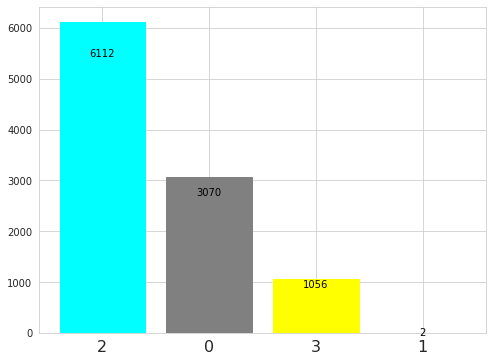

In [338]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

contro_label = train_data.doc2vec_label.value_counts()
#len(contro_label)

if len(contro_label) == 3:
    ax.bar(range(3), contro_label)
    ax.set_xticks(range(3))
    ax.set_xticklabels(contro_label.index, fontsize=16)

    for rect, c, value in zip(ax.patches, ['cyan', 'grey', 'yellow'], contro_label.values):
        rect.set_color(c)
        height = rect.get_height()
        width = rect.get_width()
        x_loc = rect.get_x()
        ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=10, color='black')
elif len(contro_label)== 4:
    ax.bar(range(4), contro_label)
    ax.set_xticks(range(4))
    ax.set_xticklabels(contro_label.index, fontsize=16)

    for rect, c, value in zip(ax.patches, ['cyan', 'grey', 'yellow','b'], contro_label.values):
        rect.set_color(c)
        height = rect.get_height()
        width = rect.get_width()
        x_loc = rect.get_x()
        ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=10, color='black')

### Plotting controversy bar chart
* 0 - non-controversial
* 1 - Weakly- controversial
* 2 - somewhat controversial
* 3 - Strongly-controversial

##### The number of controversial statements is higher than non-controversial statements

## chi2 on vectorized dataset ( including unigrams and bigrams)
* Term Frequency, Inverse Document Frequency, is used to calculate a tf-idf vector for each of the news statements:
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept.
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [339]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf_vect.fit_transform(train_data.stemmed).toarray()
labels = train_data.label_id
features.shape

(10240, 2968)

Now, each of 10240 statements is represented by 4127 features, representing the tf-idf score for different unigrams and bigrams.

In [340]:
train_data['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

### Using sklearn.feature_selection.chi2 to find the terms that are the most correlated with each:

In [341]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, label_id in sorted(label_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'barely-true':
  . Most correlated unigrams:
. penni
. bid
  . Most correlated bigrams:
. decid vote
. feder reserv
# 'false':
  . Most correlated unigrams:
. scheme
. debunk
  . Most correlated bigrams:
. kidnap capit
. vice presid
# 'half-true':
  . Most correlated unigrams:
. neutral
. dropout
  . Most correlated bigrams:
. congress pass
. fund educ
# 'mostly-true':
  . Most correlated unigrams:
. owe
. visa
  . Most correlated bigrams:
. dollar man
. rate world
# 'pants-fire':
  . Most correlated unigrams:
. transact
. socialist
  . Most correlated bigrams:
. voter fraud
. stimulus creat
# 'true':
  . Most correlated unigrams:
. compens
. counti
  . Most correlated bigrams:
. flop abort
. elect state


## A final comparison of Controversy scores
I have used three different approaches for document similarity: This will be used to find the similarity between words in the news statements and the words in the corpus.

* 1. Transform the documents into tf-idf vectors, then compute the cosine similarity between them.
* 2. Applying LDA on the corpus of vocabulary, then using the LDA model to create the vector for each document and compute similarity between the vectors and computing controversy score. 
* 3. Applying LDA on tfidf vectors.
* 4. Applying LSA on the dictionary corpus and then adding the news statements to the LSA model which vectorizes each statement and computes similarity.
* 5. Applying Doc2vec to compare the news statements and compute similarity.


### Based on my visual analysis and comparison with other scores for each news statement, I am getting more accurate score for controversy (document similarity) using Doc2vec . 
LDA TF-IDF model did not perform better, since it calculates score based on frequency of terms appearing in my vocab document.

In [342]:
train_data.keys()

Index(['id', 'label', 'statement', 'text-length', 'label_id', 'filtered_text',
       'stemmed', 'tokenized', 'sentiment_polarity', 'variance_level',
       'LSA_controversy_score', 'cosine_similarity_tfidf',
       'LDA_controversy_score', 'Topic_Keywords', 'Topic_Perc_Contrib',
       'Dominant_Topic', 'Doc2vec_score', 'doc2vec_label', 'controversy_label',
       'sentiment_label'],
      dtype='object')

In [343]:
train_data[['statement','sentiment_polarity', 'cosine_similarity_tfidf','LSA_controversy_score', 'LDA_controversy_score','Doc2vec_score']][:10]

,statement,sentiment_polarity,cosine_similarity_tfidf,LSA_controversy_score,LDA_controversy_score,Doc2vec_score
0,Says the Annies List political group supports ...,positive,0.032854,0.153393,0.989949,0.163400
1,When did the decline of coal start? It started...,positive,0.019089,0.153393,0.989949,0.562753
2,"Hillary Clinton agrees with John McCain ""by vo...",positive,0.042025,0.153393,0.989949,0.652956
3,Health care reform legislation is likely to ma...,positive,0.069592,0.306786,0.995350,0.056077
4,The economic turnaround started at the end of ...,neutral,0.000000,0.000000,0.316228,0.614075
5,The Chicago Bears have had more starting quart...,negative,0.014432,0.076696,0.964764,0.703776
6,Jim Dunnam has not lived in the district he re...,neutral,0.000000,0.000000,0.316228,0.669307
7,I'm the only person on this stage who has work...,positive,0.023099,0.076696,0.964764,0.660490
8,"However, it took $19.5 million in Oregon Lotte...",neutral,0.027803,0.153393,0.989949,0.050155
9,Says GOP primary opponents Glenn Grothman and ...,neutral,0.056884,0.306786,0.997334,0.682863


In [344]:
train_data[['statement','Doc2vec_score','LDA_controversy_score']][:5]

,statement,Doc2vec_score,LDA_controversy_score
0,Says the Annies List political group supports ...,0.163400,0.989949
1,When did the decline of coal start? It started...,0.562753,0.989949
2,"Hillary Clinton agrees with John McCain ""by vo...",0.652956,0.989949
3,Health care reform legislation is likely to ma...,0.056077,0.995350
4,The economic turnaround started at the end of ...,0.614075,0.316228


# 3. Ranking

## Rank the articles based on the Controversy scores of each statement.

In [345]:
#train_data['Statement_Controversy_Rank'] = train_data.groupby('id')['LDA_controversy_score'].rank(ascending=False)
train_data['Statement_Controversy_Rank'] = train_data['LDA_controversy_score'].rank(ascending=False)
train_data[['LDA_controversy_score','Statement_Controversy_Rank']][:5]

,LDA_controversy_score,Statement_Controversy_Rank
0,0.989949,2624.5
1,0.989949,3532.0
2,0.989949,3597.5
3,0.995350,1708.0
4,0.316228,8851.5


In [346]:
train_data.sort_values("Statement_Controversy_Rank", inplace = True) 
train_data.head()

,id,label,statement,text-length,label_id,filtered_text,stemmed,tokenized,sentiment_polarity,variance_level,LSA_controversy_score,cosine_similarity_tfidf,LDA_controversy_score,Topic_Keywords,Topic_Perc_Contrib,Dominant_Topic,Doc2vec_score,doc2vec_label,controversy_label,sentiment_label,Statement_Controversy_Rank
1280,1280,mostly-true,"Hospitals, doctors, MRIs, surgeries and so for...",3192,2,hospital doctor mri surgery expensive country ...,hospit doctor mri surgeri expens countri count...,"[hospit, doctor, mri, surgeri, expen, countri,...",positive,0.008,5.445451,0.163360,1.0,"percent, top, income, today, democrat, say, am...",0.2209,7,0.043121,0,3,0,1.0
707,707,half-true,We spend more money on health care per capita ...,286,1,spend money health care capita country world d...,spend money health care capita countri world d...,"[spend, money, health, care, capita, countri, ...",positive,0.107,0.843661,0.083294,1.0,"health, care, budget, state, insurance, year, ...",0.5421,8,0.662633,2,3,0,2.0
7550,7550,false,The vast majority of the money I got was from ...,2099,0,vast majority money get small donor country ca...,vast major money get small donor countri campa...,"[vast, major, money, get, small, donor, countr...",positive,0.022,3.374646,0.122345,1.0,"percent, top, income, today, democrat, say, am...",0.3127,7,0.561870,2,3,0,3.0
3986,3986,true,Says the Republican Party platform says pull b...,241,3,say Republican Party platform say pull rule ca...,say republican parti platform say pull rule ca...,"[say, republican, parti, platform, say, pull, ...",positive,0.201,0.920358,0.131698,1.0,"say, voter, obama, act, require, run, plan, la...",0.2230,19,0.652615,2,3,0,4.0
6119,6119,true,Georgia has the most restrictive ballot access...,1592,3,restrictive ballot access law country election...,restrict ballot access law countri elect mari ...,"[restrict, ballot, access, law, countri, elect...",negative,0.036,2.607681,0.134568,1.0,"say, mean, year, war, abortion, keep, iraq, pl...",0.1638,6,0.061214,0,3,2,5.0


# Applying Multi-class Classification Models for predicting Controversy level
* Multinomial Naive Bayes
* Linear SVC
* Support Vector Machine
* Random Forest Classifier


### Multinomial Naive Bayes

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['controversy_label'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(count_vect.transform(X_test))

In [348]:
print(clf.predict(count_vect.transform(["Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die"])))

[3]


In [349]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.780859375


### Linear SVC

In [0]:
from sklearn.svm import LinearSVC
model_SVC = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model_SVC.fit(X_train_tfidf, y_train)
y_pred_SVC = model_SVC.predict(count_vect.transform(X_test))

In [351]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_SVC))

Accuracy: 0.95078125


In [352]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 182  552]
 [   9 1817]]


              precision    recall  f1-score   support

           1       0.95      0.25      0.39       734
           3       0.77      1.00      0.87      1826

    accuracy                           0.78      2560
   macro avg       0.86      0.62      0.63      2560
weighted avg       0.82      0.78      0.73      2560



In [353]:
from sklearn import svm


clf = svm.SVC(kernel='linear') 

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(count_vect.transform(X_test))


from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.947265625


### Random Forest

In [354]:
from sklearn.ensemble import RandomForestClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train_tfidf,y_train)

y_pred=clf.predict(count_vect.transform(X_test))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9640625


In [0]:
label_id_df = train_data[['label', 'label_id']].drop_duplicates().sort_values('label_id')
category_to_id = dict(label_id_df.values)

### Using SKlearn Pipeline to run the classifiers with Countvectorizer and TfidfTransformer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['label'], test_size=0.3, random_state = 42)

In [357]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

my_tags = ['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire']

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_data['stemmed'], train_data['label'])


from sklearn.metrics import classification_report
y_pred = nb.predict(test_data['stemmed'])

print('accuracy %s' % accuracy_score(y_pred, test_data['label']))
print(classification_report(test_data['label'], y_pred,target_names=my_tags))

accuracy 0.22573007103393844
              precision    recall  f1-score   support

       false       0.29      0.09      0.14       212
   half-true       0.21      0.27      0.24       249
 mostly-true       0.23      0.45      0.30       265
        true       0.24      0.28      0.26       241
 barely-true       0.50      0.01      0.02        92
  pants-fire       0.15      0.05      0.07       208

    accuracy                           0.23      1267
   macro avg       0.27      0.19      0.17      1267
weighted avg       0.24      0.23      0.20      1267



# Training multi-label classifiers for predicting labels
## Models suitable for multinomial variant: 
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest
* Logistic Regression: A linear classifier, mostly similar to traditional linear regression, but that fits the output of the logistic function.
* (Multinomial) Naive Bayes: A Bayesian model that assumes total independence between features.  This model works  well with the Bag of Words model, and has notably been used for spam detection.
* Random Forest: Random Forest is the ensembling of a large number of decision trees, each trained on a random subset of the input features. They work well when complex feature-relations are involved and are relatively robust to overfitting.

### (Multinomial) Naive Bayes

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [359]:
print(clf.predict(count_vect.transform(["Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die"])))

['true']


In [360]:
train_data['polarity_id'] = train_data['sentiment_polarity'].factorize()[0]
train_data['polarity_id'].unique()

array([0, 1, 2])

In [361]:
test_data.shape

(1267, 16)

In [0]:
X = train_data.stemmed
y = train_data.label_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
cvec = CountVectorizer(stop_words='english').fit(X_train)
df_train = pd.DataFrame(cvec.transform(X_train).todense(),columns=cvec.get_feature_names())


In [363]:
df_test = pd.DataFrame(cvec.transform(X_test).todense(),columns=cvec.get_feature_names())
print (df_train.shape)
print (y_train.shape)
print (df_test.shape)
print (y_test.shape)

(6860, 4862)
(6860,)
(3380, 4862)
(3380,)


## LogisticRegression with CountVectorizer

In [364]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(df_train,y_train)
lr.score(df_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.22218934911242605

In [0]:
X = train_data.sentiment_polarity
y = train_data.label_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
cvec = CountVectorizer(stop_words='english').fit(X_train)
polarity_train = pd.DataFrame(cvec.transform(X_train).todense(),columns=cvec.get_feature_names())
polarity_test = pd.DataFrame(cvec.transform(X_test).todense(),columns=cvec.get_feature_names())



In [366]:
lr = LogisticRegression()
lr.fit(df_train,y_train)
lr.score(df_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.18727810650887575

In [367]:
train = pd.concat([df_train,polarity_train], axis = 1)
test = pd.concat([df_test,polarity_test],axis = 1)
print(train.shape)
print(test.shape)
print(y_train.shape)
print(y_test.shape)

(6860, 4865)
(3380, 4865)
(6860,)
(3380,)


In [368]:
lr = LogisticRegression()
lr.fit(train,y_train)
lr.score(test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.18550295857988167

#### So we did not get a good score with CountVectorizer

### Visualizing the accuracy 

In [369]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs',random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linea

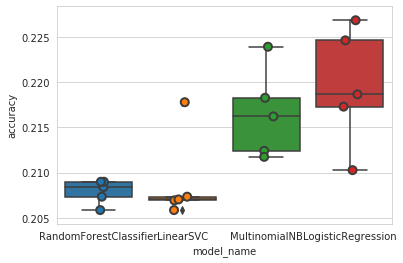

In [370]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



### Multinomial Naive Bayes and Logistic Regression perform better than the other two classifiers.
accuracy=  #correct predictions by #total data points
       

In [371]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.208985
LogisticRegression        0.219527
MultinomialNB             0.216501
RandomForestClassifier    0.207910
Name: accuracy, dtype: float64

### Using LinearSVC model to  print confusion matrix, and see the discrepancies between predicted and actual labels.

In [0]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [373]:
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.20887573964497042


### I applied the chi-squared test to find the terms that are the most correlated with each of the labels:

In [374]:
model.fit(features, labels)
N = 2
for label, label_id in sorted(label_to_id.items()):
    indices = np.argsort(model.coef_[label_id])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(label))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'barely-true':
  . Top unigrams:
       . penni
       . bid
  . Top bigrams:
       . feder reserv
       . administr spend
# 'false':
  . Top unigrams:
       . debunk
       . destroy
  . Top bigrams:
       . trade plan
       . court nomine
# 'half-true':
  . Top unigrams:
       . mammogram
       . film
  . Top bigrams:
       . congress pass
       . gas taxi
# 'mostly-true':
  . Top unigrams:
       . gunfir
       . sander
  . Top bigrams:
       . pay nation
       . employ mandat
# 'pants-fire':
  . Top unigrams:
       . transact
       . blue
  . Top bigrams:
       . stimulus creat
       . job pay
# 'true':
  . Top unigrams:
       . compens
       . sever
  . Top bigrams:
       . flop abort
       . elect state


### The classification report for each class:

In [375]:
from sklearn import metrics
print(confusion_matrix(y_test, y_pred))
print('\n')
print(metrics.classification_report(y_test, y_pred, target_names=train_data['label'].unique()))

[[170 121 131  98  93  47]
 [151 166 144  88 111  46]
 [117 141 157 107  81  34]
 [115 116 138  95  71  19]
 [110 136 103  88  83  33]
 [ 56  45  45  43  46  35]]


              precision    recall  f1-score   support

 mostly-true       0.24      0.26      0.25       660
   half-true       0.23      0.24      0.23       706
       false       0.22      0.25      0.23       637
        true       0.18      0.17      0.18       554
  pants-fire       0.17      0.15      0.16       553
 barely-true       0.16      0.13      0.14       270

    accuracy                           0.21      3380
   macro avg       0.20      0.20      0.20      3380
weighted avg       0.21      0.21      0.21      3380



### Applying CountVectorizer to fit the training statements and apply Multinomial Naive Bayes to see if there is any marginal increase in accuracy

In [0]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_data['stemmed'])

In [377]:
review_5 = train_data['statement'][4]
review_5

'The economic turnaround started at the end of my term.'

In [378]:
bow_5 = bow_transformer.transform([review_5])
print(bow_5)

  (0, 1683)	1
  (0, 5209)	1
  (0, 5409)	1


In [0]:
X = bow_transformer.transform(train_data['stemmed'])

In [0]:
X_test = bow_transformer.transform(test_data['stemmed'])

In [381]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (10240, 5853)
Amount of Non-Zero occurrences:  71575
Density: 0.11942159736459936


In [0]:
from sklearn.model_selection import train_test_split


In [383]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X, train_data['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
preds = nb.predict(X_test)

In [0]:
y_test = test_data['label']

In [386]:
print('accuracy %s' % accuracy_score(preds, y_test))

accuracy 0.23441199684293607


In [387]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 43  56  59  38   3  13]
 [ 35  60  76  50   7  21]
 [ 35  46 101  60   3  20]
 [ 31  35  77  65   2  31]
 [ 13  31  17  16   4  11]
 [ 24  44  59  52   5  24]]


              precision    recall  f1-score   support

 barely-true       0.24      0.20      0.22       212
       false       0.22      0.24      0.23       249
   half-true       0.26      0.38      0.31       265
 mostly-true       0.23      0.27      0.25       241
  pants-fire       0.17      0.04      0.07        92
        true       0.20      0.12      0.15       208

    accuracy                           0.23      1267
   macro avg       0.22      0.21      0.20      1267
weighted avg       0.23      0.23      0.22      1267



### The model accuracy is not great, so it has to be improved by boosting or ensemble methods, and adding more features to train the model and using pipeline


## To improve the model accuracy applied-
* ### Bagging 
* ### Boosting  
* ### Ensemble methods for Doc2vec model 

## Logistic Regression:
* Logistic Regression is used for Binary classifications (Sigmoid function gives probability of the two classes betweetn 0 and 1.
* For Multiclass predictions it works on different method like first predicting for two classes and then for other. 
#### Pros & Cons:
* In Multiclass Classifications its accuracy might be low when compared to other algorithms which is also seen below. But being a simple algorithm it is compuationally faster and faster to tune by hyper parameters

In [388]:
df_train_statements=train_data[['stemmed','label']]
model= Doc2Vec.load("doc2vec_model")
texts=[]
for x in df_train_statements['stemmed']:
    texts.append(model.infer_vector(x))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [389]:
df_train_statements.label.unique()

array(['mostly-true', 'half-true', 'false', 'true', 'pants-fire',
       'barely-true'], dtype=object)

In [390]:
def replace_label(x):
    if (x == 'true' or x=='mostly-true' or x=='half-true'):
        return 1
    else:
        return 0
replace_label('true')

1

## Support Vector Machine with Doc2vec model

In [0]:
from sklearn.svm import SVC

In [0]:
X=pd.DataFrame(texts)
y=df_train_statements['label'].map(lambda x:replace_label(x))
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size = .3, random_state = 1)

In [0]:
modelSVC = LinearSVC()
modelSVC.fit(X_train, y_train)
svc_pred = modelSVC.predict(X_test)
#s = pickle.dumps(modelSVC)

In [394]:
classifier_conf = SVC(kernel='linear', probability=True)
classifier_conf.fit(X_train, y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [395]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, svc_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, svc_pred, average='weighted')))

Testing accuracy 0.5478515625
Testing F1 score: 0.39736726830928476


## KNeighborsClassifier:
K Nearest Neighbors classifies Data by finding the nearest data points to it measured by a distance function and then it assigns to the class which is most common amongst its K nearest neighbors

Pros & Cons:
Since it works on similaity measures it can Easily handle multi-class cases, hence this model is selected.

Since there is No generalization in this Algorithm so the Accuracy of model totally depends on the Accuracy, In our case since we have a good Training set we acheived a good accuracy of 51%

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

In [397]:
knn_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the knn classifier with 10 fold cross-validation is ' + str(knn_scores.mean()))

The accuracy of the knn classifier with 10 fold cross-validation is 0.5034822772203585


In [398]:
print(knn_scores)

[0.49442897 0.52367688 0.49372385 0.50348675 0.50069735 0.53277545
 0.55027933 0.46927374 0.48463687 0.48184358]


In [399]:
knn_cv_mean = np.mean(knn_scores)
knn_cv_variance = np.var(knn_scores)

print('Knn Mean score : ', knn_cv_mean)
print('Knn Score variance : ', knn_cv_variance)

Knn Mean score :  0.5034822772203585
Knn Score variance :  0.0005634427947194743


## Random Forest: (Ensemble - bagging)
Since I was unable to acheive good accuracies by normal Models I opted to use Ensembles, A Bootstrap method. Especially in Random forest, it is a Bagging Model and it works by changing the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation and overall accuracy is high

Pros & Cons:
Advantage of this method is we can acheive higher accuracies, but It can also lead to overfitting of the Model which needs to be taken care. Also, Random Forest can handle Missing values, although we repleaced missing values in our case, This Model can be used even with missing values

In [400]:
forest = RandomForestClassifier()
forest_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the Random forest classifier with 10 fold cross-validation is ' + str(forest_scores.mean()))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

The accuracy of the Random forest classifier with 10 fold cross-validation is 0.5143757451008774


In [401]:
print(forest_scores)

[0.52924791 0.49582173 0.48535565 0.53695955 0.49511855 0.50209205
 0.52513966 0.52234637 0.52374302 0.52793296]


In [402]:

forest_cv_mean = np.mean(forest_scores)
forest_cv_variance = np.var(forest_scores)

print('forest Mean score : ', forest_cv_mean)
print('forest Score variance : ', forest_cv_variance)

forest Mean score :  0.5143757451008774
forest Score variance :  0.000289029274547378



### Gradient Boost: (Ensemble - Boosting)
It is a similar ensemble algorithm like Random forest, But it works in a iterative manner by selecting and creating one tree after another. In random forest all Decision trees are simultaneously perfomed. But here, We select featues of next iteration tree based on the Error rate and Feature importance obtained in one step

Pros & Cons:
Both Bias and Variance can be adjusted by doing hyper paramter tuning in this Ensemble method. So it gives us more flexibilty for tuning the Model and create Bias variance Tradeoff

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [404]:
start_gb = time.time()

gb_scores = cross_val_score(gb, X, y, cv=10, scoring='accuracy')
print('The accuracy of the Random forest classifier with 10 fold cross-validation is ' + str(gb_scores.mean()))

end_gb =time.time()
gb_time = (end_gb-start_gb)/60
print('The time taken for the classifier for 10 fold cross validation is ' + str(gb_time))

The accuracy of the Random forest classifier with 10 fold cross-validation is 0.5519560984364198
The time taken for the classifier for 10 fold cross validation is 0.27406270503997804


### The accuracy increased to 55% with GradientBoosting

## Feature Importance:
Univariate feature selection:
This method works by selecting the best features based on univariate statistical tests. It performs chi2 test for different categorical Values to get the Feature weights as done below.

In [0]:
feature_names = train_data.columns # e.g. ['A', 'B', 'C', 'D', 'E']
#plt.xticks(range(heart_train.shape[1]), feature_names)

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1. feature 16 (0.057621)
2. feature 4 (0.053534)
3. feature 11 (0.052264)
4. feature 3 (0.052256)
5. feature 9 (0.052072)
6. feature 10 (0.051160)
7. feature 0 (0.050690)
8. feature 14 (0.050573)
9. feature 8 (0.049939)
10. feature 6 (0.049313)
11. feature 5 (0.049036)
12. feature 19 (0.048700)
13. feature 13 (0.048632)
14. feature 18 (0.048606)
15. feature 15 (0.048261)
16. feature 1 (0.048082)
17. feature 2 (0.047737)
18. feature 17 (0.047334)
19. feature 7 (0.047156)
20. feature 12 (0.047032)


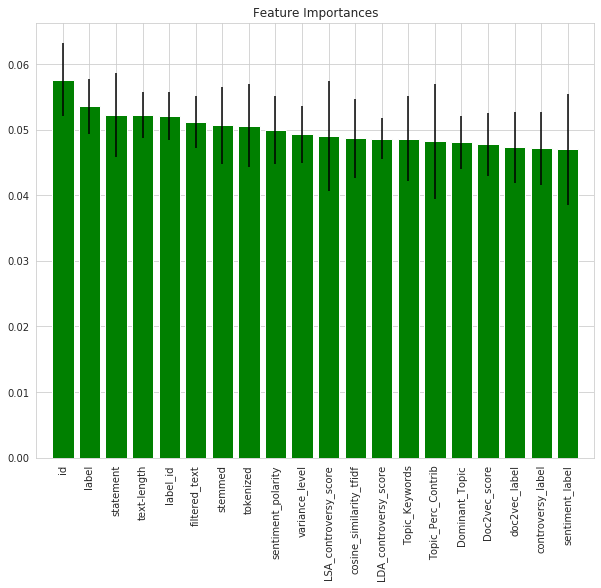

In [407]:
rcf = RandomForestClassifier()      
rcf = rcf.fit(X,y)
importances = rcf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rcf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

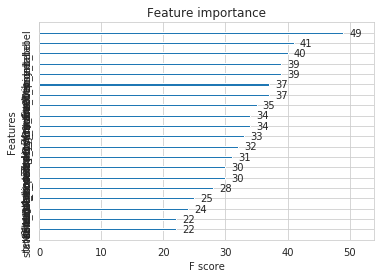

In [408]:

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X, y)


plot_importance(model)
pyplot.rcParams['figure.figsize'] = [20, 15]
pyplot.yticks(range(X.shape[1]), feature_names, rotation=90)
pyplot.show()

### Applying K Fold model for computing Accuracy score

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
seed = 7

KNN: 0.516895 (0.014273)
DTree: 0.504590 (0.009036)
NB: 0.551758 (0.009736)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

SVM: 0.561719 (0.013108)
LR: 0.561133 (0.012772)


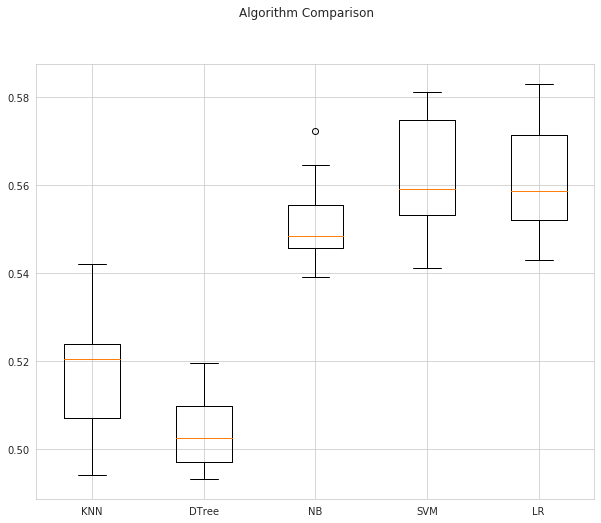

In [410]:
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(1, figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Logistic Regression

In [411]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(C=100)
logReg.fit(X_train, y_train)
log_pred = logReg.predict(X_test)
s = ""
import pickle
s = pickle.dumps(logReg)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [412]:
from sklearn import metrics
print(metrics.classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.41      0.02      0.03      1382
           1       0.55      0.98      0.70      1690

    accuracy                           0.55      3072
   macro avg       0.48      0.50      0.37      3072
weighted avg       0.49      0.55      0.40      3072



In [413]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, log_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, log_pred, average='weighted')))

Testing accuracy 0.546875
Testing F1 score: 0.401796588647523


## Got better accuracy using Logistic Regression and Support Vector Machine

### Hence, these models can be used to predict Controversy factor in news statements

## Controversy Factor Calculator

In [414]:
model= Doc2Vec.load("doc2vec_model")
def controversy_factor_calculator(news):
    data_pred=[]
    data_pred.append(model.infer_vector(news))
    lrg_pa = pickle.loads(s)
    pred_conf=lrg_pa.predict_proba(data_pred)
    return pred_conf[0][1]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
class ControversyPredictor:
    def __init__(self,news):
        self.news=news
    def predict(self):
        return controversy_checker(self.news)

In [416]:
df_train_statements['stemmed'][0]

'say anni list polit group support trimest abort demand'

In [417]:
controversy_factor_calculator("say anni list polit group support trimest abort demand")

0.5599898882937386

In [0]:
cols_of_interest = ['Doc2vec_score','variance_level']

X_doc = train_data[cols_of_interest]
y = train_data['label']
#X_doc

In [0]:
train_data_contro = train_data.head(1000)

## Export the following columns for common equation calculation

In [0]:
# import pandas
# import csv

header = ['Doc2vec_score', 'variance_level','label_id']
train_data_contro.to_csv('output_contro.csv', columns = header )

In [0]:
dataset_sample_contro = pd.read_csv('output_contro.csv')

### The score received from the above method will be passed as factor to the final equation

## Calculating final weightage of Controversy factor

---



In [422]:
X = dataset_sample_contro[['label_id','Doc2vec_score','variance_level']]

cols_of_interest = ['Doc2vec_score','variance_level']

X_doc = X[cols_of_interest]
y = X['label_id']


print(X_doc.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_doc, y, random_state=7,test_size = 0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


max_accuracy_controversy = 0
dict_threshold = {}
threshold_list = []
accuracy_list = []

for threshold in np.linspace(0,1,1000):

    clf=RandomForestClassifier(n_estimators=100)

    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    threshold_list.append(threshold)
    accuracy_list.append(accuracy)
    if accuracy > max_accuracy_controversy:
        max_accuracy_controversy = accuracy
        max_threshold_controversy= threshold
print("Max_accuracy",max_accuracy_controversy)
print("Max_threshold",max_threshold_controversy)

(1000, 2)
(1000,)
(700, 2)
(300, 2)
(700,)
(300,)
Max_accuracy 0.21666666666666667
Max_threshold 0.8908908908908909


### The Threshold and accuracy value will be passed to the final equation 

# Word2vec and T-Sne plot visualization

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this case)

In [423]:
from gensim.models import word2vec
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=200, workers=4)
model.wv['say']

array([ 0.18908581,  0.19130716,  0.13156256, -0.17535064, -0.04927829,
        0.03244624,  0.03135394,  0.03052128, -0.1171006 , -0.32041842,
        0.10810792,  0.12999079, -0.23900665, -0.10922732, -0.01220527,
       -0.02860923,  0.03266616,  0.18080969, -0.01654506,  0.12179854,
       -0.15471046, -0.09131672, -0.36437732, -0.10445652, -0.04911957,
        0.06464539,  0.13045281,  0.08032157,  0.3924347 , -0.10835122,
       -0.16269292, -0.09483899,  0.04851025, -0.0553496 , -0.07524591,
        0.02361743, -0.12463813,  0.04897803,  0.04174133,  0.08669873,
        0.1862295 , -0.0410998 ,  0.18164563, -0.02904616,  0.24976087,
        0.06115852,  0.09397815,  0.10071217,  0.10653691,  0.2766972 ,
       -0.05173336, -0.21798989,  0.01824634,  0.0322357 , -0.2518709 ,
        0.09105222, -0.20269005, -0.0325581 , -0.08165183,  0.06816984,
       -0.03211571,  0.2541275 , -0.24767053, -0.23634951,  0.0530083 ,
       -0.04115131, -0.1816852 , -0.0810403 ,  0.15411845,  0.01

### T-sne plot visualization 

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

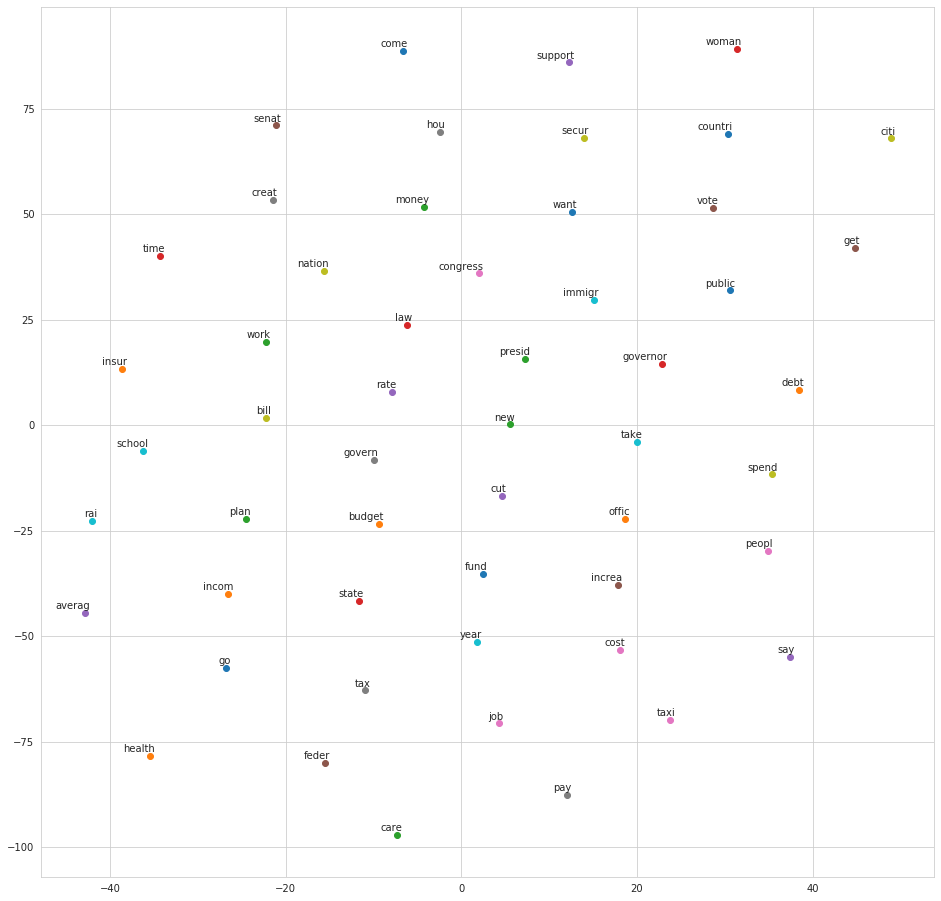

In [425]:
tsne_plot(model)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

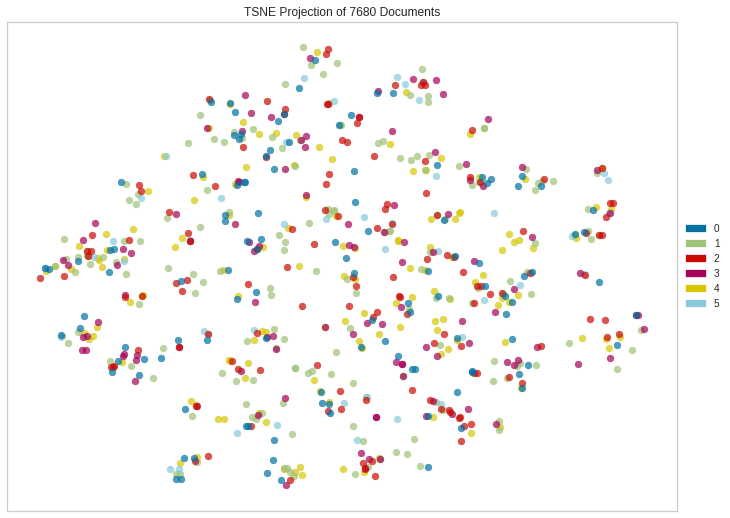

In [426]:
# Create the visualizer and draw the vectors
from yellowbrick.text import TSNEVisualizer
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
tsne.fit(X_train_tfidf, y_train)
tsne.poof()

* ### T-Sne projection of documents
#### We can clearly see that different articles categories are almost overlapping, which means that we cannot expect highly accurate classification performance.

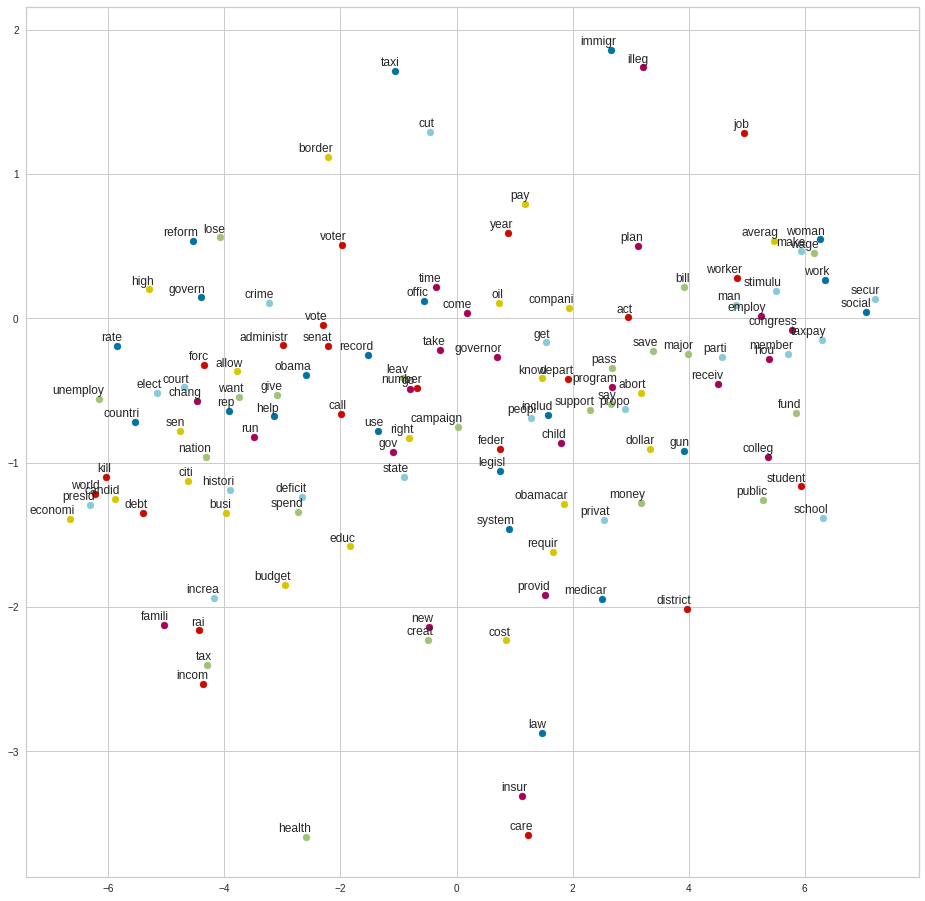

In [427]:
## A less selective model
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

#### Similar words are grouped together in the plot
#### t-SNE keeps nearby points in the high-dimensional space close to each other in the projected space.

In [428]:
model.most_similar('obama')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('know', 0.999630868434906),
 ('sen', 0.999610424041748),
 ('hou', 0.9996069669723511),
 ('includ', 0.9995883703231812),
 ('right', 0.9995816946029663),
 ('get', 0.9995807409286499),
 ('propo', 0.9995758533477783),
 ('work', 0.9995705485343933),
 ('major', 0.9995705485343933),
 ('number', 0.9995684623718262)]

In [429]:
model.most_similar('dollar')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('use', 0.9995157718658447),
 ('obama', 0.9994890093803406),
 ('stimulu', 0.9994789958000183),
 ('give', 0.9994757175445557),
 ('save', 0.9994699358940125),
 ('man', 0.9994644522666931),
 ('work', 0.9994602203369141),
 ('money', 0.9994591474533081),
 ('get', 0.9994570016860962),
 ('forc', 0.9994555711746216)]

## Conclusion - 

#### Enriched dataset with following columns - 
* Sentiment_polarity - Using Vader Library. To detect sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. Then, used the algorithm to train the emotion • polarity classifier (EP), using both the annotations and sentiment measures. I computed variance level by fiidng the differnce of positive and negative words.
* cosine_similarity_tfidf- When the documents are similar to the controversy vocabulary, it would imply that the statement is more controversial. The model accuracy was not great.
* LSA_controversy_score - The use of the LSA model shows a noticeable quality improvement compared to the use of the tfidf model.
* LDA_controversy_score - model implemented to capture the distribution of topics among news documents. I performed manual evaluations in order to understand the accuracy in similarity scores of the above Topic Models. ( LDA seems to be better than other scores)
* Doc2vec - After iplementing doc2vec model for analyzing the similarity between the controversial documents and news statements, I could analyse that Doc2vec peformed better than other models.

##### Applied following Distillation methods- 

* Sentiment Analysis
* Part of Speech Tagging
* Doc2vec
* LDA
* LSA
* Ranking


##### Applied following multiclass classification models-
* Logistic Regression 
* (Multinomial) Naive Bayes
* Support Vector Machine
* Random Forest models 
* K-nearest Neighbors
* Gradient Boosting


### Logistic Regression and SVM gave higher accuracy scores

### Applied Doc2vec model for predicting Controversy level in news statements
Controversy score was computed by applying Doc2Vec, LDA, BOW and cosine similarity. The model was trained using Random Forest Classifier, which provided threshold as 0.27 and maximum accuracy as 0.51.

The final model is trained to predict the degree of controversy feature in the news statement and its corresponding weightage using the following method-
* A Random Classifier was built to find the weightage of each factor.
* A for loop iterates between 0 and 1 to pick the best possible threshold that would give the maximum accuracy for each factor.
* For each factor the model was trained with the factor score and label value in the dataset.

Further Calculations for each factor have been performed at the Final section of the notebook. 


### References -
* https://msuweb.montclair.edu/~feldmana/publications/paper_64.pdf
* https://fzr72725.github.io/2018/01/14/genism-guide.html
* https://www.ijcai.org/proceedings/2017/0583.pdf
* https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* http://maroo.cs.umass.edu/getpdf.php?id=1118
* http://ijarcsse.com/Before_August_2017/docs/papers/Volume_7/4_April2017/V7I4-0124.pdf
* http://aclweb.org/anthology/N18-1171
* https://www.onlinejournal.in/IJIRV3I2/230.pdf
* https://petsymposium.org/2017/papers/issue1/paper06-2017-1-source.pdf
* https://nlp.stanford.edu/pubs/prabhakaran2016wiki.pdf
* https://dataskunkworks.com/2018/06/06/extracting-topics-from-11000-newsgroups-posts-with-python-gensim-and-lda/